# README

## Steps to start a new training

1. Download the dataset to "Dataset/asap_NLP_2022_Spring".<br/>
For example:<br/>
"Dataset/asap_NLP_2022_Spring/train.csv"<br/>
"Dataset/asap_NLP_2022_Spring/dev.csv"<br/>
"Dataset/asap_NLP_2022_Spring/test.csv"<br/>
2. Create "Sentiment_Analysis" folder to store the check point and the model.<br/>
3. Select IDE according to the running environment.<br/>
4. Change batch_size according to the GPU memory.<br/>
5. Switch USE_WANDB to decide whether to use wandb for logging.<br/>
6. Set RESUME to False to generate a new run_id.<br/>
7. Use brief_name to name the main change of this experiment.<br/>
8. Delete previous check point of model if exists.<br/>
For example:<br/>
"Sentiment_Analysis/cp_baseline.pt"<br/>
"Sentiment_Analysis/model_baseline.pt"<br/>
9. Run all cells.<br/>
10. A new run_id will be generated, copy it and replace the old.<br/>
For example:<br/>
Change from run_id = "old_run_id" to run_id = "new_run_id"<br/>

## Steps to resume a old training after an interruption

1. Make sure the run_id is replaced with the new one.<br/>
2. Make sure the check point has been synchronized the the drive.<br/>
For example:<br/>
The last message was "Save check point of epoch 3 at 20220522-1038" (GMT+0).<br/>
The modified date of "Sentiment_Analysis/cp_baseline.pt" in the drive should be "20220522-1838" (GMT+8).<br/>
3. Run all cells.<br/>

## Steps to test

1. Resume to an existing experiment using the 1st and 2nd step above.<br/>
2. Run the cells include "Load check point" and all above.<br/>
3. Skip the cells "Run experiment"... to prevent a training.<br/>
4. Run the all cells of "Testing".<br/>
5. Two csv files will be generated for submission.<br/>
For example:<br/>
"Sentiment_Analysis/submission_task1_baseline.csv"<br/>
"Sentiment_Analysis/submission_task2_baseline.csv"<br/>

## Reference


Text Classification | Sentiment Analysis with BERT using huggingface, PyTorch and Python Tutorial<br/>
https://www.youtube.com/watch?v=8N-nM3QW7O0<br/>
<br/>
BertTokenizer vs BertTokenizerFast<br/>
https://www.jianshu.com/p/a23ec33edaa5<br/>
<br/>
BertForSequenceClassification<br/>
https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForSequenceClassification<br/>
https://blog.csdn.net/qq_42388742/article/details/113135695<br/>
https://www.cnblogs.com/dogecheng/p/11907036.html<br/>
<br/>
MacBERT<br/>
https://huggingface.co/hfl/chinese-macbert-large<br/>
<br/>
How to use BERT<br/>
https://youtu.be/UYPa347-DdE?t=1891<br/>


# Set Environment

## Some Preparations

Select IDE

In [ ]:
IDE = "Colab"
# IDE = "Jupyter"

Mount drive

In [ ]:
if IDE == "Colab":
  from google.colab import drive
  drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Change working directory

In [ ]:
import os
if IDE == "Colab":
  os.chdir("/content/drive/MyDrive/Colab Notebooks")
  !ls
else:
  !dir

Dataset
NLP_2022_Spring_Sentiment_Analysis_0529_original.ipynb
NLP_2022_Spring_Sentiment_Analysis_balance_v1.ipynb
NLP_2022_Spring_Sentiment_Analysis_custom_0606.ipynb
NLP_2022_Spring_Sentiment_Analysis_imbalance_v1.ipynb
NLP_2022_Spring_Sentiment_Analysis_polarity.ipynb
NLP_2022_Spring_Sentiment_Analysis_v2._scheduler_v2_augmentation.ipynb
NLP_2022_Spring_Sentiment_Analysis_v2._scheduler_v2.ipynb
NLP_2022_Spring_Sentiment_Analysis_v2_sche.ipynb
Sentiment_Analysis
wandb


Install packages<br/>
% affect globally，! affect locally.<br/>
https://stackoverflow.com/a/57212513/3513289<br/>

In [ ]:
if IDE == "Colab":
  %pip install --upgrade PyYAML
  %pip install wandb
  %pip install --upgrade scikit-learn
  %pip install --upgrade --pre SimpleITK --find-links https://github.com/SimpleITK/SimpleITK/releases/tag/latest
  %pip install plotly
  %pip install timm
  %pip install transformers==4.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://github.com/SimpleITK/SimpleITK/releases/tag/latest
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import packages<br/>

In [ ]:
# Import necessary packages.
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, Dataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder
# This is for the progress bar.
# https://discuss.pytorch.org/t/error-while-multiprocessing-in-dataloader/46845/9
# import tqdm.auto as tqdm
from tqdm import tqdm
import time
from datetime import datetime
import asyncio
from glob import glob
import matplotlib.pyplot as plt
import cv2
import math
from sklearn import manifold
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pdb
import re
import wandb
import shutil
import pandas as pd
import collections
# https://stackoverflow.com/questions/47775621/interpolate-resize-3d-array
from scipy.ndimage import zoom, gaussian_filter
from scipy import signal
import importlib
import timm
from random import sample, shuffle, randrange
from transformers import AdamW, BertModel, BertForQuestionAnswering, BertForSequenceClassification, BertTokenizerFast, get_cosine_with_hard_restarts_schedule_with_warmup

## Set global variables

Set global variables

In [ ]:
"""
20220520 Andy
"batch_size": 8在Tesla P100 16G會CUDA out of memory

20220529 Andy
chinese-macbert-large在resume時，會CUDA out of memory，
改用chinese-macbert-base可解決。
"""
global_config = {
    "batch_size": 4
    , "learning_rate": 1e-5
    , "epoch_num": 20
    , "early_stop": 20
    , "max_seq_len": 512
    # , "BERT_model": "hfl/chinese-macbert-large"
    , "BERT_model": "hfl/chinese-macbert-base"
    , "doc_stride": 45
}
USE_WANDB = True
DOWNLOAD = False
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
POLARITY_TXT = ["not_mentioned", "negative", "neutral", "positive"]

Check GPU

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is {device}")
!nvidia-smi

Device is cuda
Thu Jun  9 23:59:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                         

## Set wandb

wandb resume:
1. Change RESUME to True.
2. Replace run_id with the previous one.
https://docs.wandb.ai/guides/track/advanced/resuming

In [ ]:
RESUME = True
if RESUME:
  run_id = "2sai7bkf"
else:
  run_id = wandb.util.generate_id()
print(run_id)

2sai7bkf


wandb initialize

In [ ]:
if IDE == "Jupyter":
  os.environ["WANDB_NOTEBOOK_NAME"] = "Sentiment_Analysis"
brief_name = "aspect_polarity_balanced_multi_branch_with_scheduler_and_augmentation"
if USE_WANDB:
  wandb.login()
  wandb.init(project="Sentiment_Analysis", id=run_id, resume="allow", config=global_config, entity="nlp_2022_spring_sentiment_analysis")
  if not RESUME:
    wandb.run.name = datetime.today().strftime(f"%Y%m%d-%H%M_{brief_name}")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: b07902067 (nlp_2022_spring_sentiment_analysis). Use `wandb login --relogin` to force relogin


## Set random seeds

In [ ]:
def SetSeeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True
  np.random.seed(seed)
SetSeeds(0)

# Prepare Dataset and Dataloader

## Create folders

In [ ]:
if DOWNLOAD:
  # Create main folder to save checkpoints, models, results.
  Path("Sentiment_Analysis").mkdir(parents=True, exist_ok=True)

  # Create dataset folder
  Path("Dataset").mkdir(parents=True, exist_ok=True)

  """
  20220521 Andy
  弄錯了，不能用論文的原始dataset！
  """
  # Clone dataset
  # !git clone "https://github.com/Meituan-Dianping/asap" "Dataset/asap"

## Read csv file

In [ ]:
"""
20220521 Andy
弄錯了，不能用論文的原始dataset！
"""
# USE_SAMPLE = False
# if USE_SAMPLE:
#   train = pd.read_csv("Dataset/asap/data/train_sample.csv")
#   dev = pd.read_csv("Dataset/asap/data/dev_sample.csv")
#   test = pd.read_csv("Dataset/asap/data/test_sample.csv")
# else:
#   train = pd.read_csv("Dataset/asap/data/train.csv")
#   dev = pd.read_csv("Dataset/asap/data/dev.csv")
#   test = pd.read_csv("Dataset/asap/data/test.csv")
train = pd.read_csv("Dataset/asap_NLP_2022_Spring/augumentation.csv")
dev = pd.read_csv("Dataset/asap_NLP_2022_Spring/dev.csv")
test = pd.read_csv("Dataset/asap_NLP_2022_Spring/test.csv")
print(f"Length of train is {len(train)}")
print()
print(train.head(3))

Length of train is 43516

      id                                             review  \
0  12754  鸡汤真的太一般了，我们下午去的，没什么人，鸡汤就是切好的鸡肉，全都仍在一个大铁锅里炖，每次有...   
1  43716  作为一个吃货，来云海肴二刷了，觉得好吃，难以忘记的味道，还是可以来吃吃的，鸡丝凉面，特别滑顺...   
2   3319  朋友过生日在这里搞了一个生日趴。圈出一片区域全是我们的人，装饰了气球，背景。感觉蛮好的。一般...   

   Location#Transportation  Location#Downtown  Location#Easy_to_find  \
0                       -2                 -2                     -2   
1                       -2                 -2                     -2   
2                       -2                 -2                     -2   

   Service#Queue  Service#Hospitality  Service#Parking  Service#Timely  \
0             -2                    0               -2              -1   
1             -2                    1               -2              -2   
2              1                    1               -2              -2   

   Price#Level  Price#Cost_effective  Price#Discount  Ambience#Decoration  \
0           -2                    -2              -2      

## Check review length

Collect review lengths

In [ ]:
review_len_list = []
for csv_rows in [train, dev, test]:
  for row_i in range(len(csv_rows)):
    row = csv_rows.iloc[row_i]
    review = row["review"]
    review_len_list.append(len(review))

Show length counts

In [ ]:
review_len_dict = collections.Counter(review_len_list)
review_len_most = review_len_dict.most_common(1)
review_len_sort = sorted(review_len_dict.items())
print(f"review_len_most is {review_len_most}")
print(f"review_len_dict is {review_len_dict}")
print(f"review_len_sort is {review_len_sort}")

review_len_most is [(206, 525)]
review_len_dict is Counter({206: 525, 210: 522, 201: 522, 207: 511, 209: 511, 205: 508, 208: 497, 211: 491, 202: 487, 200: 472, 212: 471, 204: 469, 203: 460, 215: 454, 213: 454, 217: 452, 219: 446, 220: 440, 216: 427, 225: 425, 214: 415, 227: 406, 221: 402, 223: 399, 218: 396, 230: 391, 232: 381, 224: 380, 222: 377, 229: 375, 228: 374, 226: 369, 233: 369, 231: 359, 235: 337, 240: 324, 237: 323, 234: 323, 238: 323, 236: 320, 244: 319, 239: 312, 245: 306, 241: 304, 247: 298, 249: 298, 252: 292, 255: 289, 246: 284, 242: 282, 248: 281, 243: 277, 254: 275, 256: 269, 253: 268, 260: 265, 251: 259, 261: 257, 267: 255, 259: 254, 250: 253, 257: 245, 258: 242, 266: 237, 270: 233, 262: 225, 268: 222, 269: 221, 265: 218, 264: 214, 272: 212, 273: 210, 263: 209, 280: 209, 276: 206, 274: 204, 271: 200, 278: 198, 275: 194, 310: 193, 277: 191, 284: 191, 307: 188, 279: 188, 295: 187, 303: 184, 282: 184, 289: 182, 315: 182, 281: 180, 302: 180, 300: 179, 290: 178, 308: 176, 

Show length bar

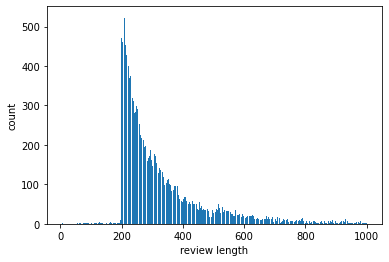

In [ ]:
labels, values = zip(*review_len_sort)
plt.bar(x=labels, height=values)
plt.xlabel("review length")
plt.ylabel("count")
plt.savefig(r"Sentiment_Analysis/review_length_bar.png")
plt.show()

## Prepare dataset

Load tokenizer

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(global_config["BERT_model"])

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Convert review into review_aspect pairs

In [ ]:
csv_rows = train
review_aspect_pair_list = []
for row_i in range(len(csv_rows)):
    row = csv_rows.iloc[row_i]
    review = row["review"]
    review_tokens = tokenizer(review, add_special_tokens=False)
    # review_tokens_inputs = review_tokens["input_ids"]
    # review_tokens_types = review_tokens["token_type_ids"]
    # review_tokens_masks = review_tokens["attention_mask"]
    review_tokens_inputs = review_tokens["input_ids"]
    review_tokens_types = review_tokens["token_type_ids"]
    review_tokens_masks = review_tokens["attention_mask"]

    """
    review_aspect_pair_list內容示意
    [
    {'aspect_tokens_label': [769, 6858, 3175, 912],
      'polarity_label': 3,
      'review_id': 46277,
      'review_tokens_inputs': [4307, ...]}
    ,{'aspect_tokens_label': [855, 754, 1555, 1750, 7353, 6818],
      'polarity_label': 3,
      'review_id': 46277,
      'review_tokens_inputs': [4307, ...]}
    , ...
    ]
    """
    for aspect_id, aspect_eng in enumerate([
        "Location#Transportation" # "交通方便"
      , "Location#Downtown"    # "位于商圈附近"
      , "Location#Easy_to_find"  # "是否容易寻找"
      , "Service#Queue"      # "排队时间"
      , "Service#Hospitality"   # "服务人员态度"
      , "Service#Parking"     # "停车方便"
      , "Service#Timely"     # "点菜或上菜速度"
      , "Price#Level"       # "价格水平"
      , "Price#Cost_effective"  # "性价比"
      , "Price#Discount"     # "折扣力度"
      , "Ambience#Decoration"   # "装修"
      , "Ambience#Noise"     # "嘈杂情况"
      , "Ambience#Space"     # "就餐空间"
      , "Ambience#Sanitary"    # "卫生情况"
      , "Food#Portion"      # "分量"
      , "Food#Taste"       # "口味"
      , "Food#Appearance"     # "外观"
      , "Food#Recommend"     # "推荐程度"
    ]):
      review_aspect_pair = {}
      review_aspect_pair["review_id"] = row["id"]
      """
      20220603 Andy
      配合data及submission格式，
      Shift aspect_id from [0, 17] to [1, 18]
      """
      review_aspect_pair["aspect_id"] = aspect_id + 1
      review_aspect_pair["aspect_eng"] = aspect_eng
      review_aspect_pair["review_tokens_inputs"] = review_tokens_inputs
      # Shift polarity from [-2, 1] to [0, 3]
      review_aspect_pair["polarity_label"] = row[aspect_eng] + 2
      review_aspect_pair_list.append(review_aspect_pair)
    break

Get one data from the list

In [ ]:
"""
char的index跟token的index，
目前是1:1對應關係，
所以不需要char_to_token轉換
https://xiaosheng.run/2022/03/08/transformers-note-5.html
"""
token_index = review_tokens.char_to_token(50)
print(f"token_index is {token_index}")

# Get one data from the list
review_aspect_pair = review_aspect_pair_list[0]
print(f"review_aspect_pair is {review_aspect_pair}")
review_id = review_aspect_pair["review_id"]
print(f"review_id is {review_id}")
aspect_id = review_aspect_pair["aspect_id"]
print(f"aspect_id is {aspect_id}")
review_tokens_inputs = review_aspect_pair["review_tokens_inputs"]
print(f"review_tokens_inputs is {review_tokens_inputs}")
print(f"len(review_tokens_inputs) is {len(review_tokens_inputs)}")
review = tokenizer.decode(review_aspect_pair["review_tokens_inputs"], clean_up_tokenization_spaces=True)
print(f"review is {review}")
aspect_eng = review_aspect_pair["aspect_eng"]
print(f"aspect_eng is {aspect_eng}")
polarity = review_aspect_pair["polarity_label"]
print(f"polarity is {polarity}")

token_index is 50
review_aspect_pair is {'review_id': 12754, 'aspect_id': 1, 'aspect_eng': 'Location#Transportation', 'review_tokens_inputs': [7883, 3739, 4696, 4638, 1922, 671, 5663, 749, 8024, 2769, 812, 678, 1286, 1343, 4638, 8024, 3766, 784, 720, 782, 8024, 7883, 3739, 2218, 3221, 1147, 1962, 4638, 7883, 5489, 8024, 1059, 6963, 793, 1762, 671, 702, 1920, 7188, 7222, 7027, 4146, 8024, 3680, 3613, 3300, 2145, 782, 4157, 4638, 3198, 952, 8024, 2218, 4670, 671, 819, 1139, 3341, 8024, 2792, 809, 2769, 812, 6821, 671, 7222, 7883, 3739, 2218, 3221, 3300, 4638, 5489, 2523, 4162, 8024, 6963, 2347, 5307, 6809, 1168, 5564, 7755, 4638, 1765, 3635, 8024, 3300, 4638, 6820, 2523, 4801, 8024, 1490, 679, 1220, 511, 7883, 5489, 7608, 3332, 1236, 2487, 5050, 3173, 7831, 8043, 1456, 6887, 4696, 4638, 1922, 2192, 2382, 749, 8024, 2769, 722, 1184, 5307, 2382, 5632, 2346, 1762, 2157, 4216, 7883, 3739, 8024, 1372, 6206, 7883, 1916, 3173, 7831, 8024, 679, 7444, 6206, 1217, 784, 720, 6444, 3160, 8024, 5042,

Convert review_aspect_pair to model input for training

In [ ]:
# Get dynamic window, 101×1 + 102×1 = 2
max_review_len = global_config["max_seq_len"] - 2
print(f"max_review_len is {max_review_len}")
if max_review_len > len(review_tokens_inputs):
  # window_start is included
  window_start = 0
  # window_end isn't included
  window_end = len(review_tokens_inputs)
else:
  # right_most is included
  right_most = len(review_tokens_inputs) - max_review_len
  # stop isn't included
  window_start = randrange(0, right_most + 1)
  # window_end isn't included
  window_end = window_start + max_review_len
print(f"window_start is {window_start}")
print(f"window_end is {window_end}")
window_review_tokens = review_tokens_inputs[window_start:window_end]

# Add special tokens (101: CLS, 102: SEP)
window_review_tokens = [101] + window_review_tokens + [102]
print(f"window_review_tokens is {window_review_tokens}")

# Padding
padding_len = global_config["max_seq_len"] - len(window_review_tokens)
print(f"padding_len is {padding_len}")
input_ids = window_review_tokens + [0] * padding_len
print(f"input_ids is {input_ids}")
# Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]
attention_mask = [1] * len(window_review_tokens) + [0] * padding_len
print(f"attention_mask is {attention_mask}")

max_review_len is 510
window_start is 0
window_end is 272
window_review_tokens is [101, 7883, 3739, 4696, 4638, 1922, 671, 5663, 749, 8024, 2769, 812, 678, 1286, 1343, 4638, 8024, 3766, 784, 720, 782, 8024, 7883, 3739, 2218, 3221, 1147, 1962, 4638, 7883, 5489, 8024, 1059, 6963, 793, 1762, 671, 702, 1920, 7188, 7222, 7027, 4146, 8024, 3680, 3613, 3300, 2145, 782, 4157, 4638, 3198, 952, 8024, 2218, 4670, 671, 819, 1139, 3341, 8024, 2792, 809, 2769, 812, 6821, 671, 7222, 7883, 3739, 2218, 3221, 3300, 4638, 5489, 2523, 4162, 8024, 6963, 2347, 5307, 6809, 1168, 5564, 7755, 4638, 1765, 3635, 8024, 3300, 4638, 6820, 2523, 4801, 8024, 1490, 679, 1220, 511, 7883, 5489, 7608, 3332, 1236, 2487, 5050, 3173, 7831, 8043, 1456, 6887, 4696, 4638, 1922, 2192, 2382, 749, 8024, 2769, 722, 1184, 5307, 2382, 5632, 2346, 1762, 2157, 4216, 7883, 3739, 8024, 1372, 6206, 7883, 1916, 3173, 7831, 8024, 679, 7444, 6206, 1217, 784, 720, 6444, 3160, 8024, 5042, 1296, 4638, 5876, 2002, 8024, 4500, 4773, 7222, 2218, 

Convert review_aspect_pair to model input for testing

In [ ]:
doc_stride = global_config["doc_stride"]
print(f"doc_stride is {doc_stride}")
print(f"len(review_tokens_inputs) is {len(review_tokens_inputs)}")
for window_start in range(0, len(review_tokens_inputs), doc_stride):
  # Get dynamic window, 101×1 + 102×1 = 2
  max_review_len = global_config["max_seq_len"] - 2
  window_review_tokens = review_tokens_inputs[window_start : window_start + max_review_len]
  print(f"len(window_review_tokens) is {len(window_review_tokens)}")
  window_review_tokens += [102]
  break

doc_stride is 45
len(review_tokens_inputs) is 272
len(window_review_tokens) is 272


Combine above into ABSDataset

In [ ]:
"""
20220525 Andy
ABSDataset、CustomBalanceLoader都會用到
"""
def GetWindow(max_seq_len, review_tokens_inputs):
  # Get dynamic window, 101×1 + 102×1 = 2
  max_review_len = max_seq_len - 2
  # print(f"max_review_len is {max_review_len}")
  if max_review_len > len(review_tokens_inputs):
    # window_start is included
    window_start = 0
    # window_end isn't included
    window_end = len(review_tokens_inputs)
  else:
    # right_most is included
    right_most = len(review_tokens_inputs) - max_review_len
    # stop isn't included
    window_start = randrange(0, right_most + 1)
    # window_end isn't included
    window_end = window_start + max_review_len
  return window_start, window_end

def Padding(max_seq_len, window_review_tokens):
  padding_len = max_seq_len - len(window_review_tokens)
  # print(f"padding_len is {padding_len}")
  input_ids = window_review_tokens + [0] * padding_len
  # print(f"input_ids is {input_ids}")
  # Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]
  attention_mask = [1] * len(window_review_tokens) + [0] * padding_len
  # print(f"attention_mask is {attention_mask}")  
  return input_ids, attention_mask

class ABSDataset(Dataset):
  def __init__(self, fold_name, csv_rows, max_seq_len, doc_stride):
    self.fold_name = fold_name
    self.csv_rows = csv_rows
    self.max_seq_len = max_seq_len
    self.doc_stride = doc_stride

    # Convert review into review_aspect pairs
    review_aspect_pair_list = []
    for row_i in range(len(self.csv_rows)):
        row = self.csv_rows.iloc[row_i]
        review = row["review"]
        review_tokens = tokenizer(review, add_special_tokens=False)
        review_tokens_inputs = review_tokens["input_ids"]
        review_tokens_types = review_tokens["token_type_ids"]
        review_tokens_masks = review_tokens["attention_mask"]

        for aspect_id, aspect_eng in enumerate([
            "Location#Transportation" # "交通方便"
          , "Location#Downtown"    # "位于商圈附近"
          , "Location#Easy_to_find"  # "是否容易寻找"
          , "Service#Queue"      # "排队时间"
          , "Service#Hospitality"   # "服务人员态度"
          , "Service#Parking"     # "停车方便"
          , "Service#Timely"     # "点菜或上菜速度"
          , "Price#Level"       # "价格水平"
          , "Price#Cost_effective"  # "性价比"
          , "Price#Discount"     # "折扣力度"
          , "Ambience#Decoration"   # "装修"
          , "Ambience#Noise"     # "嘈杂情况"
          , "Ambience#Space"     # "就餐空间"
          , "Ambience#Sanitary"    # "卫生情况"
          , "Food#Portion"      # "分量"
          , "Food#Taste"       # "口味"
          , "Food#Appearance"     # "外观"
          , "Food#Recommend"     # "推荐程度"
        ]):
          review_aspect_pair = {}
          review_aspect_pair["review_id"] = row["id"]
          """
          20220603 Andy
          配合data及submission格式，
          Shift aspect_id from [0, 17] to [1, 18]。
          但是CustomDataLoader因為list的特性，aspect_id的range仍然是[0, 17]
          """
          review_aspect_pair["aspect_id"] = aspect_id + 1
          review_aspect_pair["aspect_eng"] = aspect_eng
          review_aspect_pair["review_tokens_inputs"] = review_tokens_inputs
          # Shift polarity from [-2, 1] to [0, 3]
          if fold_name == "test":
            review_aspect_pair["polarity_label"] = None
          else:
            review_aspect_pair["polarity_label"] = row[aspect_eng] + 2
          review_aspect_pair_list.append(review_aspect_pair)       
    self.review_aspect_pair_list = review_aspect_pair_list

  def __len__(self):
    return len(self.review_aspect_pair_list)

  def GetDataBeforeWindow(self, idx):
    """
    20220525 Andy
    獨立抽出此方法，除了__getitem__使用，
    還供CustomBalanceLoader使用。

    內容示意：
    review_aspect_pair is {'review_id': 12754, 'aspect_id': 1, 'aspect_eng': 'Location#Transportation', 'review_tokens_inputs': [7883, 3739, 4696, 4638, 1922, 671, 5663, 749, 8024, 2769, 812, 678, 1286, 1343, 4638, 8024, 3766, 784, 720, 782, 8024, 7883, 3739, 2218, 3221, 1147, 1962, 4638, 7883, 5489, 8024, 1059, 6963, 793, 1762, 671, 702, 1920, 7188, 7222, 7027, 4146, 8024, 3680, 3613, 3300, 2145, 782, 4157, 4638, 3198, 952, 8024, 2218, 4670, 671, 819, 1139, 3341, 8024, 2792, 809, 2769, 812, 6821, 671, 7222, 7883, 3739, 2218, 3221, 3300, 4638, 5489, 2523, 4162, 8024, 6963, 2347, 5307, 6809, 1168, 5564, 7755, 4638, 1765, 3635, 8024, 3300, 4638, 6820, 2523, 4801, 8024, 1490, 679, 1220, 511, 7883, 5489, 7608, 3332, 1236, 2487, 5050, 3173, 7831, 8043, 1456, 6887, 4696, 4638, 1922, 2192, 2382, 749, 8024, 2769, 722, 1184, 5307, 2382, 5632, 2346, 1762, 2157, 4216, 7883, 3739, 8024, 1372, 6206, 7883, 1916, 3173, 7831, 8024, 679, 7444, 6206, 1217, 784, 720, 6444, 3160, 8024, 5042, 1296, 4638, 5876, 2002, 8024, 4500, 4773, 7222, 2218, 5543, 4215, 1139, 6375, 782, 3617, 5387, 679, 5543, 4638, 7676, 1456, 8024, 6821, 2157, 2421, 712, 2802, 7946, 7883, 8024, 1316, 3766, 1391, 1139, 671, 692, 2661, 1599, 8024, 3300, 4157, 1927, 3307, 511, 7946, 6486, 5576, 6158, 6890, 2563, 749, 8024, 6963, 2571, 1391, 2130, 749, 998, 749, 697, 3613, 1296, 2798, 5314, 976, 8024, 1366, 2697, 6820, 679, 7231, 8024, 852, 3221, 6655, 4895, 3302, 1218, 1447, 2792, 6458, 4638, 100, 2553, 4157, 510, 679, 1377, 7231, 6814, 100, 2345, 749, 4696, 679, 3221, 671, 3215, 1288, 4157, 8024, 2597, 679, 2533, 2190, 7481, 2961, 7339, 2961, 1168, 679, 6121, 8024, 800, 812, 2157, 738, 1372, 5543, 5335, 2898, 702, 1777, 4007, 1416], 'polarity_label': 0}
    review_id is 12754
    aspect_id is 1
    review_tokens_inputs is [7883, 3739, 4696, 4638, 1922, 671, 5663, 749, 8024, 2769, 812, 678, 1286, 1343, 4638, 8024, 3766, 784, 720, 782, 8024, 7883, 3739, 2218, 3221, 1147, 1962, 4638, 7883, 5489, 8024, 1059, 6963, 793, 1762, 671, 702, 1920, 7188, 7222, 7027, 4146, 8024, 3680, 3613, 3300, 2145, 782, 4157, 4638, 3198, 952, 8024, 2218, 4670, 671, 819, 1139, 3341, 8024, 2792, 809, 2769, 812, 6821, 671, 7222, 7883, 3739, 2218, 3221, 3300, 4638, 5489, 2523, 4162, 8024, 6963, 2347, 5307, 6809, 1168, 5564, 7755, 4638, 1765, 3635, 8024, 3300, 4638, 6820, 2523, 4801, 8024, 1490, 679, 1220, 511, 7883, 5489, 7608, 3332, 1236, 2487, 5050, 3173, 7831, 8043, 1456, 6887, 4696, 4638, 1922, 2192, 2382, 749, 8024, 2769, 722, 1184, 5307, 2382, 5632, 2346, 1762, 2157, 4216, 7883, 3739, 8024, 1372, 6206, 7883, 1916, 3173, 7831, 8024, 679, 7444, 6206, 1217, 784, 720, 6444, 3160, 8024, 5042, 1296, 4638, 5876, 2002, 8024, 4500, 4773, 7222, 2218, 5543, 4215, 1139, 6375, 782, 3617, 5387, 679, 5543, 4638, 7676, 1456, 8024, 6821, 2157, 2421, 712, 2802, 7946, 7883, 8024, 1316, 3766, 1391, 1139, 671, 692, 2661, 1599, 8024, 3300, 4157, 1927, 3307, 511, 7946, 6486, 5576, 6158, 6890, 2563, 749, 8024, 6963, 2571, 1391, 2130, 749, 998, 749, 697, 3613, 1296, 2798, 5314, 976, 8024, 1366, 2697, 6820, 679, 7231, 8024, 852, 3221, 6655, 4895, 3302, 1218, 1447, 2792, 6458, 4638, 100, 2553, 4157, 510, 679, 1377, 7231, 6814, 100, 2345, 749, 4696, 679, 3221, 671, 3215, 1288, 4157, 8024, 2597, 679, 2533, 2190, 7481, 2961, 7339, 2961, 1168, 679, 6121, 8024, 800, 812, 2157, 738, 1372, 5543, 5335, 2898, 702, 1777, 4007, 1416]
    len(review_tokens_inputs) is 272
    review is 鸡 汤 真 的 太 一 般 了 ， 我 们 下 午 去 的 ， 没 什 么 人 ， 鸡 汤 就 是 切 好 的 鸡 肉 ， 全 都 仍 在 一 个 大 铁 锅 里 炖 ， 每 次 有 客 人 点 的 时 候 ， 就 盛 一 份 出 来 ， 所 以 我 们 这 一 锅 鸡 汤 就 是 有 的 肉 很 烂 ， 都 已 经 达 到 脱 骨 的 地 步 ， 有 的 还 很 硬 ， 咬 不 动 。 鸡 肉 食 材 勉 强 算 新 鲜 ？ 味 道 真 的 太 寻 常 了 ， 我 之 前 经 常 自 己 在 家 煲 鸡 汤 ， 只 要 鸡 够 新 鲜 ， 不 需 要 加 什 么 调 料 ， 简 单 的 葱 姜 ， 用 砂 锅 就 能 煮 出 让 人 欲 罢 不 能 的 香 味 ， 这 家 店 主 打 黑 鸡 ， 却 没 吃 出 一 丝 惊 喜 ， 有 点 失 望 。 黑 豆 腐 被 遗 忘 了 ， 都 快 吃 完 了 催 了 两 次 单 才 给 做 ， 口 感 还 不 错 ， 但 是 距 离 服 务 员 所 谓 的 [UNK] 必 点 、 不 可 错 过 [UNK] 差 了 真 不 是 一 星 半 点 ， 怪 不 得 对 面 排 队 排 到 不 行 ， 他 们 家 也 只 能 维 持 个 坐 满 吧
    aspect_eng is Location#Transportation
    polarity is 0

    Train
    max_review_len is 508
    window_start is 0
    window_end is 230
    input_aspect_tokens is [101, 769, 6858, 3175, 912, 102]
    window_review_tokens is [4307, 1039, 3517, 7649, 2421, 5018, 671, 3613, 1343, 8024, 1728, 711, 1765, 4415, 855, 5390, 831, 6632, 8038, 1762, 2123, 3797, 2356, 1469, 721, 1920, 6887, 7770, 510, 1920, 510, 677, 8024, 7027, 7481, 6163, 934, 704, 2466, 8024, 5831, 3221, 1765, 6887, 4638, 2123, 3797, 5831, 8024, 1366, 1456, 5283, 3633, 8024, 7004, 3799, 6090, 4294, 3472, 8024, 1391, 1168, 749, 2207, 3198, 952, 4638, 1456, 6887, 8024, 1728, 711, 1343, 749, 3241, 749, 8024, 1762, 1920, 1828, 5023, 749, 671, 833, 1036, 8024, 3309, 7313, 3300, 5763, 3717, 1600, 510, 3302, 1218, 1447, 6820, 680, 872, 5464, 1921, 8024, 1168, 749, 2218, 7623, 3198, 4495, 2692, 1922, 1962, 8024, 3302, 1218, 1447, 6963, 3221, 2207, 6651, 4307, 8024, 3302, 1218, 2578, 2428, 5318, 2190, 679, 2990, 6862, 8024, 3416, 3416, 6963, 3302, 1218, 1168, 855, 8024, 4157, 6983, 3717, 6820, 5447, 2552, 4638, 680, 2769, 812, 6237, 7025, 8024, 2218, 6821, 3416, 5318, 2190, 6206, 1930, 671, 1930, 8024, 4294, 1166, 3221, 2510, 3173, 3215, 510, 3825, 5326, 1290, 8020, 4692, 3302, 1218, 4277, 2798, 4761, 6887, 1399, 2099, 8021, 738, 5314, 2769, 812, 2123, 3797, 2356, 2501, 6496, 1872, 5682, 8024, 4307, 1039, 3517, 3221, 2123, 3797, 4638, 671, 2794, 4970, 1366, 8024, 3302, 1218, 1447, 4638, 5162, 6574, 3291, 860, 4385, 2769, 812, 2123, 3797, 782, 4638, 5125, 4868, 7481, 6505, 511, 6614, 671, 702, 102]
    padding_len is 275
    input_ids is [101, 769, 6858, 3175, 912, 102, 4307, 1039, 3517, 7649, 2421, 5018, 671, 3613, 1343, 8024, 1728, 711, 1765, 4415, 855, 5390, 831, 6632, 8038, 1762, 2123, 3797, 2356, 1469, 721, 1920, 6887, 7770, 510, 1920, 510, 677, 8024, 7027, 7481, 6163, 934, 704, 2466, 8024, 5831, 3221, 1765, 6887, 4638, 2123, 3797, 5831, 8024, 1366, 1456, 5283, 3633, 8024, 7004, 3799, 6090, 4294, 3472, 8024, 1391, 1168, 749, 2207, 3198, 952, 4638, 1456, 6887, 8024, 1728, 711, 1343, 749, 3241, 749, 8024, 1762, 1920, 1828, 5023, 749, 671, 833, 1036, 8024, 3309, 7313, 3300, 5763, 3717, 1600, 510, 3302, 1218, 1447, 6820, 680, 872, 5464, 1921, 8024, 1168, 749, 2218, 7623, 3198, 4495, 2692, 1922, 1962, 8024, 3302, 1218, 1447, 6963, 3221, 2207, 6651, 4307, 8024, 3302, 1218, 2578, 2428, 5318, 2190, 679, 2990, 6862, 8024, 3416, 3416, 6963, 3302, 1218, 1168, 855, 8024, 4157, 6983, 3717, 6820, 5447, 2552, 4638, 680, 2769, 812, 6237, 7025, 8024, 2218, 6821, 3416, 5318, 2190, 6206, 1930, 671, 1930, 8024, 4294, 1166, 3221, 2510, 3173, 3215, 510, 3825, 5326, 1290, 8020, 4692, 3302, 1218, 4277, 2798, 4761, 6887, 1399, 2099, 8021, 738, 5314, 2769, 812, 2123, 3797, 2356, 2501, 6496, 1872, 5682, 8024, 4307, 1039, 3517, 3221, 2123, 3797, 4638, 671, 2794, 4970, 1366, 8024, 3302, 1218, 1447, 4638, 5162, 6574, 3291, 860, 4385, 2769, 812, 2123, 3797, 782, 4638, 5125, 4868, 7481, 6505, 511, 6614, 671, 702, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    token_type_ids is [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    attention_mask is [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    Validation, testing
    doc_stride is 45

    """
    review_aspect_pair = self.review_aspect_pair_list[idx]
    # print(f"review_aspect_pair is {review_aspect_pair}")
    review_id = review_aspect_pair["review_id"]
    aspect_id = review_aspect_pair["aspect_id"]
    review_tokens_inputs = review_aspect_pair["review_tokens_inputs"]
    # print(f"review_tokens_inputs is {review_tokens_inputs}")
    # print(f"len(review_tokens_inputs) is {len(review_tokens_inputs)}")
    review = tokenizer.decode(review_aspect_pair["review_tokens_inputs"], clean_up_tokenization_spaces=True)
    # print(f"review is {review}")
    aspect_eng = review_aspect_pair["aspect_eng"]
    # print(f"aspect_eng is {aspect_eng}")    
    polarity = review_aspect_pair["polarity_label"]
    # print(f"polarity is {polarity}")
    """
    20220514 Andy
    RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for
    https://stackoverflow.com/questions/69742930/runtimeerror-nll-loss-forward-reduce-cuda-kernel-2d-index-not-implemented-for
    CrossEntropyLoss的target必須是int64, LongTensor

    20220520 Andy
    在Dataset中應回傳原始int，
    DataLoader那邊才轉成LongTensor
    """
    # polarity = torch.LongTensor([polarity])
    return review_id, aspect_id, review_tokens_inputs, aspect_eng, polarity

  def __getitem__(self, idx):
    review_id, aspect_id, review_tokens_inputs, aspect_eng, polarity = self.GetDataBeforeWindow(idx)

    if self.fold_name == "train":
      # Get dynamic window
      window_start, window_end = GetWindow(max_seq_len=self.max_seq_len, review_tokens_inputs=review_tokens_inputs)
      window_review_tokens = [101] + review_tokens_inputs[window_start:window_end] + [102]

      # Padding
      input_ids, attention_mask = Padding(max_seq_len=self.max_seq_len, window_review_tokens=window_review_tokens)
      return review_id, aspect_id, torch.tensor(input_ids), torch.tensor(attention_mask), aspect_eng, polarity
    else:
      # validation, testing
      input_ids_list, attention_mask_list = [], []
      # print(f"len(review_tokens_inputs) is {len(review_tokens_inputs)}")
      # Get dynamic window, 101×1 + 102×1 = 2
      max_review_len = self.max_seq_len - 2
      for window_start in range(0, len(review_tokens_inputs), self.doc_stride):
        # Add special tokens (101: CLS, 102: SEP)
        window_end = window_start + max_review_len
        window_review_tokens = [101] + review_tokens_inputs[window_start : window_end] + [102]
        # print(f"len(window_review_tokens) is {len(window_review_tokens)}")

        # Padding
        input_ids, attention_mask = Padding(max_seq_len=self.max_seq_len, window_review_tokens=window_review_tokens)
        input_ids_list.append(input_ids)
        attention_mask_list.append(attention_mask)
        if window_end > len(review_tokens_inputs):
          break
      if self.fold_name == "test":
        return review_id, aspect_id, torch.tensor(input_ids_list), torch.tensor(attention_mask_list), aspect_eng
      else:
        return review_id, aspect_id, torch.tensor(input_ids_list), torch.tensor(attention_mask_list), aspect_eng, polarity

Initialize dataset

In [ ]:
train_set = ABSDataset(fold_name="train", csv_rows=train, max_seq_len=global_config["max_seq_len"], doc_stride=global_config["doc_stride"])
dev_set = ABSDataset(fold_name="dev", csv_rows=dev, max_seq_len=global_config["max_seq_len"], doc_stride=global_config["doc_stride"])
test_set = ABSDataset(fold_name="test", csv_rows=test, max_seq_len=global_config["max_seq_len"], doc_stride=global_config["doc_stride"])

## Prepare dataloader

Group by aspect, polarity

In [ ]:
"""
Initialize 2-D list to store aspect, polarity
18 aspect
4 polarity
array_aspect_polarity.shape is (18, 4, 0)
array_aspect_polarity is []
list_aspect_polarity is [[[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []]]
"""
array_aspect_polarity = np.empty((18, 4, 0))
print(f"array_aspect_polarity.shape is {array_aspect_polarity.shape}")
print(f"array_aspect_polarity is {array_aspect_polarity}")
list_aspect_polarity = array_aspect_polarity.tolist()
print(f"list_aspect_polarity is {list_aspect_polarity}")
print()

"""
Group by aspect, polarity
POLARITY_TXT = ["not_mentioned", "negative", "neutral", "positive"]
aspect_id range is [1, 18]
polarity range is [0, 3]
"""
print("Start grouping data by aspect, polarity")
len_set = len(train_set)
for i in range(len_set):
  print(f"\r[{i}/{len_set}]", end="")
  review_id, aspect_id, review_tokens_inputs, aspect_eng, polarity = train_set.GetDataBeforeWindow(i)
  list_aspect_polarity[aspect_id - 1][polarity].append((review_id, aspect_id, review_tokens_inputs, aspect_eng, polarity))
print()

"""
Show lengths and get the minimum.
Each group will be down-sampled to the minimum later
Minimum is aspect 1, polarity 2, length 131
"""
min_aspect = ""
min_polarity = ""
min_data_len = math.inf
for aspect in range(18):
  for polarity in range(4):
    group_len = len(list_aspect_polarity[aspect][polarity])
    print(f"Aspect {aspect}, polarity {polarity}, length {group_len}")
    if group_len < min_data_len:
      min_aspect = aspect
      min_polarity = polarity
      min_data_len = group_len
  print()
print(f"Minimum is aspect {min_aspect}, polarity {min_polarity}, length {min_data_len}")
  

array_aspect_polarity.shape is (18, 4, 0)
array_aspect_polarity is []
list_aspect_polarity is [[[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []], [[], [], [], []]]

Start grouping data by aspect, polarity
[783287/783288]
Aspect 0, polarity 0, length 34675
Aspect 0, polarity 1, length 506
Aspect 0, polarity 2, length 351
Aspect 0, polarity 3, length 7984

Aspect 1, polarity 0, length 35880
Aspect 1, polarity 1, length 216
Aspect 1, polarity 2, length 171
Aspect 1, polarity 3, length 7249

Aspect 2, polarity 0, length 34901
Aspect 2, polarity 1, length 1488
Aspect 2, polarity 2, length 825
Aspect 2, polarity 3, length 6302

Aspect 3, polarity 0, length 37023
Aspect 3, polarity 1, length 1896
Aspect 3, polarity 2, length 2423
Aspect 3, po

Calculate total number per class

In [ ]:
"""
Drop the remainder.
Calculate total number per class.
total_num_per_polarity is 131
batch_num_per_aspect is 131
total_batch_num is 2358
"""
aspect_num = 18
polarity_num = 4
polarity_per_batch = global_config["batch_size"] // polarity_num
batch_remainder = min_data_len % polarity_per_batch
total_num_per_polarity = int(min_data_len - batch_remainder)
print(f"total_num_per_polarity is {total_num_per_polarity}")
batch_num_per_aspect = total_num_per_polarity // polarity_per_batch
print(f"batch_num_per_aspect is {batch_num_per_aspect}")
total_batch_num = batch_num_per_aspect * aspect_num
print(f"total_batch_num is {total_batch_num}")

total_num_per_polarity is 171
batch_num_per_aspect is 171
total_batch_num is 3078


Random sample and random sort

In [ ]:
array_aspect_polarity_sample = np.empty((18, 4, 0))
list_aspect_polarity_sample = array_aspect_polarity_sample.tolist()
for aspect in range(18):
  print(f"aspect {aspect}")
  for polarity in range(4):
    print(f"polarity {polarity}")
    sample_aspect_polarity = sample(list_aspect_polarity[aspect][polarity], total_num_per_polarity)
    list_aspect_polarity_sample[aspect][polarity] = sample_aspect_polarity
    print(f"len(sample_aspect_polarity) is {len(sample_aspect_polarity)}")
    print(f"sample_aspect_polarity[0:3] is {sample_aspect_polarity[0:3]}")
  print()

aspect 0
polarity 0
len(sample_aspect_polarity) is 171
sample_aspect_polarity[0:3] is [(43030, 1, [3796, 5696, 3796, 5696, 3796, 5696, 671, 1366, 678, 1343, 4007, 4007, 4638, 1959, 3779, 3980, 1139, 8024, 4494, 2428, 4924, 2544, 4494, 749, 671, 4157, 8024, 6134, 4649, 6763, 2075, 8024, 5543, 671, 678, 2094, 1391, 6822, 1343, 697, 702, 1391, 5018, 676, 702, 2218, 6421, 5594, 749, 8024, 3241, 677, 1343, 743, 4385, 4171, 7481, 1259, 6820, 3300, 1197, 8024, 3373, 677, 4638, 7481, 1259, 738, 2923, 705, 2168, 4638, 8024, 5018, 671, 3613, 2214, 6407, 100, 6205, 2094, 4635, 7434, 100, 7481, 1259, 3146, 860, 1366, 2697, 3221, 5336, 5336, 4638, 8024, 6820, 3300, 1959, 3779, 1762, 1912, 1741, 1259, 4708, 8024, 2697, 6230, 1456, 6887, 6820, 679, 7231, 8024, 129, 1039, 671, 702, 817, 3419, 679, 912, 2139, 1450, 8024, 707, 6818, 1760, 6414, 5688, 6820, 677, 749, 5291, 3344, 6028, 5130, 8024, 7270, 2533, 2523, 1377, 4263, 8024, 8108, 1039, 671, 702, 511, 2398, 2128, 3362, 738, 2458, 1993, 1297, 6629,

Get one balanced batch

In [ ]:
batch = []
batch_id = 0
batch_aspect = batch_id % 18

for polarity_id in range(4):
  polarity_data = list_aspect_polarity_sample[batch_aspect][polarity_id].pop()
  review_id, aspect_id, review_tokens_inputs, aspect_eng, polarity = polarity_data

  # Get dynamic window
  window_start, window_end = GetWindow(max_seq_len=global_config["max_seq_len"], review_tokens_inputs=review_tokens_inputs)
  window_review_tokens = [101] + review_tokens_inputs[window_start:window_end] + [102]

  # Padding
  input_ids, attention_mask = Padding(max_seq_len=global_config["max_seq_len"], window_review_tokens=window_review_tokens)
  batch.append((review_id, aspect_id, input_ids, attention_mask, aspect_eng, polarity))
print(f"len(batch) is {len(batch)}")
print(f"batch is {batch}")

len(batch) is 4
batch is [(38617, 1, [101, 1762, 6813, 7720, 2408, 1767, 4638, 1724, 3517, 5401, 7608, 2231, 722, 1184, 2218, 1420, 6432, 6821, 2157, 4171, 7824, 2523, 1962, 1391, 791, 1921, 3633, 1962, 1453, 3189, 3341, 6821, 7027, 2214, 671, 2214, 678, 1286, 2571, 758, 4157, 1343, 4638, 2218, 2347, 5307, 6206, 4007, 749, 1377, 6224, 6821, 7027, 4638, 1456, 6887, 1429, 2471, 749, 679, 2208, 782, 6821, 2157, 7623, 1324, 3221, 809, 3862, 6592, 4374, 711, 712, 7579, 4638, 4171, 7824, 2421, 671, 6822, 2421, 7027, 2218, 2697, 1168, 749, 3849, 3849, 4638, 1220, 4035, 3698, 2622, 6163, 934, 2523, 679, 7231, 1456, 6887, 2523, 679, 7231, 139, 139, 156, 3302, 1218, 1447, 2578, 2428, 2523, 1962, 5314, 749, 1048, 6589, 4638, 4178, 3717, 3344, 2094, 738, 3221, 3862, 6592, 4374, 4638, 4157, 749, 7937, 6793, 3926, 3736, 7824, 6981, 749, 1063, 702, 5831, 782, 2523, 1914, 852, 677, 5831, 738, 2523, 2571, 4007, 4007, 4638, 6793, 3492, 1469, 7937, 3492, 4692, 6629, 3341, 6375, 782, 3837, 1366, 3717, 221

Shoffle and zip

In [ ]:
"""
review_id_batch is (42362, 318, 14253, 34946)
aspect_id_batch is (5, 14, 8, 3)
len(input_ids_batch) is 4
input_ids_batch結構為([], [], [], [])
attention_mask_batch結構為([], [], [], [])
aspect_eng_batch is ('Location#Transportation', 'Location#Transportation', 'Location#Transportation', 'Location#Transportation')
olarity_batch is (2, 3, 1, 0)
"""
shuffle(batch)
review_id_batch, aspect_id_batch, input_ids_batch, attention_mask_batch, aspect_eng_batch, polarity_batch = zip(*batch)
print(f"review_id_batch is {review_id_batch}")
print(f"aspect_id_batch is {aspect_id_batch}")
print(f"len(input_ids_batch) is {len(input_ids_batch)}")
print(f"input_ids_batch is {input_ids_batch}")
print(f"len(attention_mask_batch) is {len(attention_mask_batch)}")
print(f"attention_mask_batch is {attention_mask_batch}")
print(f"len(aspect_eng_batch) is {len(aspect_eng_batch)}")
print(f"aspect_eng_batch is {aspect_eng_batch}")
print(f"polarity_batch is {polarity_batch}")

review_id_batch is (77335, 22365, 38617, 39391)
aspect_id_batch is (1, 1, 1, 1)
len(input_ids_batch) is 4
input_ids_batch is ([101, 794, 2207, 2218, 1762, 6568, 4007, 6125, 6929, 4638, 691, 1298, 7660, 2411, 743, 7481, 1259, 6028, 5130, 1391, 4638, 8024, 6821, 3221, 5018, 671, 3613, 5381, 677, 6579, 743, 4385, 7032, 1318, 743, 7481, 1259, 6028, 5130, 1391, 8024, 2923, 1153, 5050, 4638, 511, 809, 1184, 1215, 6814, 833, 1447, 1305, 8024, 852, 3766, 6821, 3175, 912, 511, 4684, 2970, 2897, 1384, 4772, 2218, 1377, 809, 4500, 8024, 4696, 2552, 679, 7231, 8013, 2421, 7027, 4638, 3302, 1218, 1447, 738, 2523, 4178, 2658, 8024, 7481, 1259, 4638, 1366, 1456, 738, 2523, 679, 7231, 8013, 817, 3419, 3683, 1343, 2399, 6586, 749, 671, 4157, 4157, 8024, 6028, 5130, 1366, 2697, 4294, 1162, 1962, 8013, 1959, 3779, 5301, 5594, 8024, 6028, 5130, 3382, 3265, 8024, 5439, 782, 2207, 2111, 6963, 6844, 1394, 1391, 511, 2769, 2157, 2140, 2140, 4692, 6224, 2769, 743, 749, 671, 702, 2207, 6028, 5130, 5314, 1961, 1

Adjust data type and shape

In [ ]:
"""
review_id_batch.shape is torch.Size([4])
review_id_batch is tensor([ 1300.,  7399., 38289., 10448.])
aspect_id_batch.shape is torch.Size([4])
aspect_id_batch is tensor([14.,  8.,  2.,  3.])
input_ids_batch.shape is torch.Size([4, 512])
input_ids_batch is tensor([[ 101., 1310., 4495.,  ..., 5770., 5803.,  102.],
        [ 101.,  817., 3419.,  ...,    0.,    0.,    0.],
        [ 101.,  855.,  754.,  ...,    0.,    0.,    0.],
        [ 101., 3221., 1415.,  ...,    0.,    0.,    0.]])
attention_mask_batch.shape is torch.Size([4, 512])
attention_mask_batch is tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])
aspect_eng_batch is ('Location#Transportation', 'Location#Transportation', 'Location#Transportation', 'Location#Transportation')
polarity_batch.type() is torch.LongTensor
polarity_batch.shape is torch.Size([4])
polarity_batch is tensor([2, 1, 3, 0])
"""
review_id_batch = torch.LongTensor(review_id_batch)
print(f"review_id_batch.shape is {review_id_batch.shape}")
print(f"review_id_batch is {review_id_batch}")
aspect_id_batch = torch.LongTensor(aspect_id_batch)
print(f"aspect_id_batch.shape is {aspect_id_batch.shape}")
print(f"aspect_id_batch is {aspect_id_batch}")
input_ids_batch = torch.LongTensor(input_ids_batch)
print(f"input_ids_batch.shape is {input_ids_batch.shape}")
print(f"input_ids_batch is {input_ids_batch}")
attention_mask_batch = torch.LongTensor(attention_mask_batch)
print(f"attention_mask_batch.shape is {attention_mask_batch.shape}")
print(f"attention_mask_batch is {attention_mask_batch}")
print(f"aspect_eng_batch is {aspect_eng_batch}")
"""
CrossEntropyLoss的target：
1. Type
在Dataset應回傳原始int，
在DataLoader應轉成int64, LongTensor
否則會出現error：
RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for
https://stackoverflow.com/questions/69742930/runtimeerror-nll-loss-forward-reduce-cuda-kernel-2d-index-not-implemented-for
2. Shape
shape必須是[N]，而非[]，
否則會出現error：
IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)
https://stackoverflow.com/a/48389451/3513289
"""
polarity_batch = torch.LongTensor(polarity_batch)
print(f"polarity_batch.type() is {polarity_batch.type()}")
print(f"polarity_batch.shape is {polarity_batch.shape}")
print(f"polarity_batch is {polarity_batch}")

review_id_batch.shape is torch.Size([4])
review_id_batch is tensor([77335, 22365, 38617, 39391])
aspect_id_batch.shape is torch.Size([4])
aspect_id_batch is tensor([1, 1, 1, 1])
input_ids_batch.shape is torch.Size([4, 512])
input_ids_batch is tensor([[ 101,  794, 2207,  ...,    0,    0,    0],
        [ 101, 1343, 2408,  ..., 4157,  749,  102],
        [ 101, 1762, 6813,  ...,    0,    0,    0],
        [ 101,  677,  702,  ...,    0,    0,    0]])
attention_mask_batch.shape is torch.Size([4, 512])
attention_mask_batch is tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
aspect_eng_batch is ('Location#Transportation', 'Location#Transportation', 'Location#Transportation', 'Location#Transportation')
polarity_batch.type() is torch.LongTensor
polarity_batch.shape is torch.Size([4])
polarity_batch is tensor([3, 1, 0, 2])


Combine above into CustomBalanceLoader

In [ ]:
class CustomBalanceLoader:
  def __init__(self, list_aspect_polarity, batch_size, aspect_num, polarity_num, max_seq_len):
    self.max_seq_len = max_seq_len

    """
    20220527 Andy
    注意：
    assign變數前，要用copy()，後續使用才會call by value，
    否則，後續使用會call by reverence，用到外部定義的，造成error
    """
    self.list_aspect_polarity = list_aspect_polarity.copy()

    """
    Show lengths and get the minimum.
    Each group will be down-sampled to the minimum later
    Minimum is aspect 1, polarity 2, length 131
    """
    min_aspect = ""
    min_polarity = ""
    min_data_len = math.inf
    for aspect in range(18):
      for polarity in range(4):
        group_len = len(self.list_aspect_polarity[aspect][polarity])
        # print(f"Aspect {aspect}, polarity {polarity}, length {group_len}")
        if group_len < min_data_len:
          min_aspect = aspect
          min_polarity = polarity
          min_data_len = group_len
      # print()
    print(f"Minimum is aspect {min_aspect}, polarity {min_polarity}, length {min_data_len}")

    """
    Drop the remainder.
    Calculate total number per class.
    total_num_per_polarity is 131
    batch_num_per_aspect is 131
    total_batch_num is 2358
    """
    polarity_per_batch = batch_size // polarity_num
    batch_remainder = min_data_len % polarity_per_batch
    self.total_num_per_polarity = int(min_data_len - batch_remainder)
    print(f"total_num_per_polarity is {self.total_num_per_polarity}")
    self.batch_num_per_aspect = self.total_num_per_polarity // polarity_per_batch
    print(f"batch_num_per_aspect is {self.batch_num_per_aspect}")
    self.total_batch_num = self.batch_num_per_aspect * aspect_num
    print(f"total_batch_num is {self.total_batch_num}")    
    
    """
    Random sample and random sort  
    """  
    self.Resample()
    self.batch_id = 0

  def Resample(self):
    array_aspect_polarity_sample = np.empty((18, 4, 0))
    self.list_aspect_polarity_sample = array_aspect_polarity_sample.tolist()
    for aspect in range(18):
      # print(f"aspect {aspect}")
      for polarity in range(4):
        # print(f"polarity {polarity}")
        sample_aspect_polarity = sample(self.list_aspect_polarity[aspect][polarity], self.total_num_per_polarity)
        self.list_aspect_polarity_sample[aspect][polarity] = sample_aspect_polarity
        # print(f"len(sample_aspect_polarity) is {len(sample_aspect_polarity)}")
        # print(f"sample_aspect_polarity[0:3] is {sample_aspect_polarity[0:3]}")
      # print()

  def __iter__(self):
    self.Resample()
    self.batch_id = 0
    return self

  def __len__(self):
    return self.total_batch_num

  def __next__(self):
    batch_aspect = self.batch_id % 18

    """
    Stop condition

    20220527 Andy
    注意：
    叫用變數前，要加self，
    否則會用到外部定義的，造成error

    20220528 Andy
    忘記寫StopIteration了！
    難怪跑到最後都會error！
    補上處理。
    """    
    # print(f"batch_id is {self.batch_id}")
    # print(f"batch_aspect is {batch_aspect}")
    for polarity_id in range(4):
      group_len = len(self.list_aspect_polarity_sample[batch_aspect][polarity_id])
      # print(f"group_len is {group_len}")
      if group_len == 0:
        raise StopIteration

    """
    Get one balanced batch
    """
    batch = []
    for polarity_id in range(4):
      polarity_data = self.list_aspect_polarity_sample[batch_aspect][polarity_id].pop()
      review_id, aspect_id, review_tokens_inputs, aspect_eng, polarity = polarity_data

      # Get dynamic window
      window_start, window_end = GetWindow(max_seq_len=self.max_seq_len, review_tokens_inputs=review_tokens_inputs)
      window_review_tokens = [101] + review_tokens_inputs[window_start:window_end] + [102]

      # Padding
      input_ids, attention_mask = Padding(max_seq_len=self.max_seq_len, window_review_tokens=window_review_tokens)
      batch.append((review_id, aspect_id, input_ids, attention_mask, aspect_eng, polarity))

    """
    Shoffle and zip
    review_id_batch is (42362, 318, 14253, 34946)
    aspect_id_batch is (5, 14, 8, 3)
    len(input_ids_batch) is 4
    input_ids_batch結構為([], [], [], [])
    attention_mask_batch結構為([], [], [], [])
    aspect_eng_batch is ('Location#Transportation', 'Location#Transportation', 'Location#Transportation', 'Location#Transportation')
    olarity_batch is (2, 3, 1, 0)
    """
    shuffle(batch)
    review_id_batch, aspect_id_batch, input_ids_batch, attention_mask_batch, aspect_eng_batch, polarity_batch = zip(*batch)

    """
    review_id_batch.shape is torch.Size([4])
    review_id_batch is tensor([ 1300.,  7399., 38289., 10448.])
    aspect_id_batch.shape is torch.Size([4])
    aspect_id_batch is tensor([14.,  8.,  2.,  3.])
    input_ids_batch.shape is torch.Size([4, 512])
    input_ids_batch is tensor([[ 101., 1310., 4495.,  ..., 5770., 5803.,  102.],
            [ 101.,  817., 3419.,  ...,    0.,    0.,    0.],
            [ 101.,  855.,  754.,  ...,    0.,    0.,    0.],
            [ 101., 3221., 1415.,  ...,    0.,    0.,    0.]])
    attention_mask_batch.shape is torch.Size([4, 512])
    attention_mask_batch is tensor([[1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 0., 0., 0.],
            [1., 1., 1.,  ..., 0., 0., 0.],
            [1., 1., 1.,  ..., 0., 0., 0.]])
    aspect_eng_batch is ('Location#Transportation', 'Location#Transportation', 'Location#Transportation', 'Location#Transportation')
    polarity_batch.type() is torch.LongTensor
    polarity_batch.shape is torch.Size([4])
    polarity_batch is tensor([2, 1, 3, 0])
    """
    review_id_batch = torch.LongTensor(review_id_batch)
    aspect_id_batch = torch.LongTensor(aspect_id_batch)
    input_ids_batch = torch.LongTensor(input_ids_batch)
    attention_mask_batch = torch.LongTensor(attention_mask_batch)

    """
    CrossEntropyLoss的target：
    1. Type
    在Dataset應回傳原始int，
    在DataLoader應轉成int64, LongTensor
    否則會出現error：
    RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for
    https://stackoverflow.com/questions/69742930/runtimeerror-nll-loss-forward-reduce-cuda-kernel-2d-index-not-implemented-for
    2. Shape
    shape必須是[N]，而非[]，
    否則會出現error：
    IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)
    https://stackoverflow.com/a/48389451/3513289
    """
    polarity_batch = torch.LongTensor(polarity_batch)

    self.batch_id += 1
    return review_id_batch, aspect_id_batch, input_ids_batch, attention_mask_batch, aspect_eng_batch, polarity_batch

Initialize dataloader

In [ ]:
# train_loader = DataLoader(train_set, batch_size=global_config["batch_size"], shuffle=True, pin_memory=True)
train_loader = CustomBalanceLoader(list_aspect_polarity=list_aspect_polarity, batch_size=global_config["batch_size"], aspect_num=aspect_num, polarity_num=len(POLARITY_TXT), max_seq_len=global_config["max_seq_len"])
print(f"len(train_loader) is {len(train_loader)}")
dev_loader = DataLoader(dev_set, batch_size=1, shuffle=False, pin_memory=True)
print(f"len(dev_loader) is {len(dev_loader)}")
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True)
print(f"len(test_loader) is {len(test_loader)}")


Minimum is aspect 1, polarity 2, length 171
total_num_per_polarity is 171
batch_num_per_aspect is 171
total_batch_num is 3078
len(train_loader) is 3078
len(dev_loader) is 76770
len(test_loader) is 76050


## Show some data

Show some training data

In [ ]:
for i in range(len(train_set)):
  data_pair = train_set.GetDataBeforeWindow(i)
  print(f"data_pair is {data_pair}")
  review_id, aspect_id, review_tokens_inputs, aspect_eng, polarity = train_set.GetDataBeforeWindow(i)
  print(f"review_id is {review_id}")
  print(f"aspect_id is {aspect_id}")
  print(f"review_tokens_inputs is {review_tokens_inputs}")
  print(f"aspect_eng is {aspect_eng}")
  print(f"polarity is {polarity}")
  break

data_pair is (12754, 1, [7883, 3739, 4696, 4638, 1922, 671, 5663, 749, 8024, 2769, 812, 678, 1286, 1343, 4638, 8024, 3766, 784, 720, 782, 8024, 7883, 3739, 2218, 3221, 1147, 1962, 4638, 7883, 5489, 8024, 1059, 6963, 793, 1762, 671, 702, 1920, 7188, 7222, 7027, 4146, 8024, 3680, 3613, 3300, 2145, 782, 4157, 4638, 3198, 952, 8024, 2218, 4670, 671, 819, 1139, 3341, 8024, 2792, 809, 2769, 812, 6821, 671, 7222, 7883, 3739, 2218, 3221, 3300, 4638, 5489, 2523, 4162, 8024, 6963, 2347, 5307, 6809, 1168, 5564, 7755, 4638, 1765, 3635, 8024, 3300, 4638, 6820, 2523, 4801, 8024, 1490, 679, 1220, 511, 7883, 5489, 7608, 3332, 1236, 2487, 5050, 3173, 7831, 8043, 1456, 6887, 4696, 4638, 1922, 2192, 2382, 749, 8024, 2769, 722, 1184, 5307, 2382, 5632, 2346, 1762, 2157, 4216, 7883, 3739, 8024, 1372, 6206, 7883, 1916, 3173, 7831, 8024, 679, 7444, 6206, 1217, 784, 720, 6444, 3160, 8024, 5042, 1296, 4638, 5876, 2002, 8024, 4500, 4773, 7222, 2218, 5543, 4215, 1139, 6375, 782, 3617, 5387, 679, 5543, 4638, 7676,

In [ ]:
for i, batch in enumerate(train_loader):
  if i == 1:
    break
  review_id_batch, aspect_id_batch, input_ids_batch, attention_mask_batch, aspect_eng_batch, polarity_batch = batch
  """
  內容示意：
  review_id_batch.shape is torch.Size([4])
  aspect_id_batch.shape is torch.Size([4])
  input_ids_batch.shape is torch.Size([4, 512])
  attention_mask_batch.shape is torch.Size([4, 512])
  len(aspect_eng_batch) is 4
  polarity_batch.shape is torch.Size([4])
  """
  print(f"review_id_batch.shape is {review_id_batch.shape}")
  print(f"aspect_id_batch.shape is {aspect_id_batch.shape}")
  print(f"input_ids_batch.shape is {input_ids_batch.shape}")
  print(f"attention_mask_batch.shape is {attention_mask_batch.shape}")
  print(f"len(aspect_eng_batch) is {len(aspect_eng_batch)}")
  print(f"polarity_batch.shape is {polarity_batch.shape}")
  print()
  for j, data in enumerate(zip(review_id_batch, aspect_id_batch, input_ids_batch, attention_mask_batch, aspect_eng_batch, polarity_batch)):
    """
    內容示意：
    len(data) is 6
    input_ids.shape is torch.Size([512])
    attention_mask.shape is torch.Size([512])
    polarity.shape is torch.Size([])
    review_id is 34532
    aspect_id is 1
    input_str is [CLS] 这 家 店 位 于 东 港 凯 丹 广 场 3 楼 ， 可 以 乘 坐 地 铁 2 号 线 会 议 中 心 站 ， 还 是 蛮 方 便 的 ， 吃 他 家 的 158 元 的 自 助 餐 ， 团 购 价 是 145 元 ， 可 用 餐 3 个 小 时 ， 自 助 餐 可 以 选 择 转 台 上 的 也 可 以 单 点 ， 感 觉 单 点 要 比 转 台 东 西 多 ， 酒 水 饮 料 都 是 自 取 的 有 啤 酒 ， 可 乐 ， 雪 碧 ， 橙 汁 ， 红 茶 等 ， 转 台 上 有 生 鱼 片 ， 寿 司 ， 大 福 ， 还 有 牛 肉 ， 牛 肉 还 需 要 加 热 基 本 上 做 成 铁 板 牛 肉 ， 感 觉 味 道 一 般 般 里 面 有 筋 ， 有 肉 的 腥 味 没 处 理 好 ， 大 福 好 吃 口 感 很 棒 ， 基 本 上 日 料 都 要 点 刺 身 ， 点 了 个 刺 身 品 牌 ， 食 材 还 算 新 鲜 ， 在 转 台 上 取 了 一 份 芥 末 章 鱼 ， 味 道 挺 特 殊 的 ， 芥 末 不 是 那 种 冲 人 的 程 度 章 鱼 口 感 很 有 嚼 劲 ， 不 错 ， 点 了 5 只 阿 根 廷 红 虾 很 大 只 盐 烤 的 味 道 不 错 ， 他 家 主 要 是 寿 司 ， 推 荐 他 家 焦 糖 系 列 的 ， 焦 糖 鳗 鱼 焦 糖 三 文 鱼 ， 焦 糖 金 枪 鱼 ， 是 那 种 炙 烤 做 法 ， 味 道 不 错 ， 铁 板 羊 排 做 得 不 好 ， 肥 肉 一 大 块 ， 哎 ， 建 议 十 一 点 多 去 ， 转 台 上 东 西 会 挺 多 选 择 ， 此 外 他 家 服 务 很 好 ， 还 有 个 机 器 人 上 菜 人 少 时 服 务 员 给 上 菜 ， 人 多 时 机 器 人 就 来 了 ， 比 较 有 意 思 。 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
    aspect_eng is Location#Transportation
    polarity is 3
    """
    print(f"len(data) is {len(data)}")
    review_id, aspect_id, input_ids, attention_mask, aspect_eng, polarity = data
    print(f"input_ids.shape is {input_ids.shape}")
    print(f"attention_mask.shape is {attention_mask.shape}")
    print(f"polarity.shape is {polarity.shape}")
    print(f"review_id is {review_id}")
    input_str = tokenizer.decode(input_ids)
    print(f"aspect_id is {aspect_id}")
    print(f"input_str is {input_str}")
    print(f"aspect_eng is {aspect_eng}")
    print(f"polarity is {polarity.item()}")
    print()

review_id_batch.shape is torch.Size([4])
aspect_id_batch.shape is torch.Size([4])
input_ids_batch.shape is torch.Size([4, 512])
attention_mask_batch.shape is torch.Size([4, 512])
len(aspect_eng_batch) is 4
polarity_batch.shape is torch.Size([4])

len(data) is 6
input_ids.shape is torch.Size([512])
attention_mask.shape is torch.Size([512])
polarity.shape is torch.Size([])
review_id is 27569
aspect_id is 1
input_str is [CLS] 家 里 人 聚 会 ， 没 有 多 拍 照 片 ， 听 说 是 杨 浦 地 区 比 较 有 名 的 饭 馆 ， 对 于 我 来 说 交 通 方 便 ， 周 边 没 有 地 铁 ， 点 了 好 多 菜 ， 冷 盆 ， 凉 拌 金 针 菇 是 我 的 最 爱 ， 她 们 家 还 多 加 了 肚 子 拌 一 起 ， 很 美 味 ， 鸭 子 太 老 ， 盐 局 鸡 我 个 人 觉 得 一 般 ， 没 有 大 饭 堂 的 好 吃 ， 素 鲍 菇 老 公 的 最 爱 ， 热 菜 第 一 个 油 爆 虾 ， 炸 的 很 透 ， 味 道 一 般 ， 酸 菜 鱼 肉 质 很 肥 厚 ， 开 背 虾 蒜 蓉 的 ， 虾 太 多 吃 不 完 ， 虾 仁 还 不 错 ， 特 色 咸 蹄 胖 味 道 还 不 错 ， 面 疙 瘩 里 面 还 有 蟹 吊 味 道 ， 响 油 鳝 丝 味 道 不 错 ， 甜 甜 的 ， 大 葱 炒 肥 牛 也 不 错 ， 回 家 做 做 ， 一 品 鲜 豆 腐 听 鲜 美 ， 点 心 三 个 ， 炒 面 没 人 吃 ， 葱 油 饼 很 棒 都 吃 完 了 ， 韭 菜 肉 的 好 吃 ， 小 圆 子 酒 酿 味 道 没 了 ， 草 头 来 不 及 拍 了 只 好 补 麻 麻 做 的 照 片 嘿 嘿 ， 味 道 还 是 这 里 的

Show some dev data

In [ ]:
for i, batch in enumerate(dev_loader):
  if i == 1:
    break
  review_id, aspect_id, input_ids_list, attention_mask_list, aspect_eng_batch, polarity = batch
  """
  內容示意：
  review_id.shape is torch.Size([1])
  aspect_id.shape is torch.Size([1])
  input_ids_list.shape is torch.Size([1, 4, 512])
  attention_mask_list.shape is torch.Size([1, 4, 512])
  len(aspect_eng_batch) is 1
  polarity.shape is torch.Size([1])
  """
  print(f"review_id.shape is {review_id.shape}")
  print(f"aspect_id.shape is {aspect_id.shape}")
  print(f"input_ids_list.shape is {input_ids_list.shape}")
  print(f"attention_mask_list.shape is {attention_mask_list.shape}")
  print(f"len(aspect_eng_batch) is {len(aspect_eng_batch)}")
  print(f"polarity.shape is {polarity.shape}")
  print()

  """
  20220523 Andy
  Polarity的shape必須是[N]，而非[]，
  作為CrossEntropyLoss的target，才會正常，
  否則會出現error：
  IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)
  https://stackoverflow.com/a/48389451/3513289
  """
  review_id, aspect_id, input_ids_list, attention_mask_list = torch.squeeze(review_id, 0), torch.squeeze(aspect_id, 0), torch.squeeze(input_ids_list, 0), torch.squeeze(attention_mask_list, 0)
  """
  內容示意：
  review_id is 4415
  aspect_id is 1
  aspect_eng is Location#Transportation
  polarity.shape is torch.Size([1])
  polarity is 0  
  """
  print(f"review_id is {review_id}")
  print(f"aspect_id is {aspect_id}")
  print(f"aspect_eng is {aspect_eng}")
  print(f"polarity.shape is {polarity.shape}")
  print(f"polarity is {polarity.item()}")
  print()
  for window_i, window in enumerate(zip(input_ids_list, attention_mask_list)):
    """
    內容示意：
    window_i is 0
    input_ids.shape is torch.Size([512])
    attention_mask.shape is torch.Size([512])
    input_str is [CLS] 理 想 是 随 便 到 楼 下 吃 碗 拉 面 ， 现 实 是 看 着 面 前 那 碟 貌 似 孤 独 的 芥 末 ， 最 后 还 是 吃 寿 司 的 欲 望 占 了 上 风 ， 于 是 拉 面 被 我 无 情 的 抛 弃 了 ， 又 开 始 了 孤 独 的 吃 寿 司 过 程 。 \ \ n 小 店 的 面 积 太 小 ， 无 奈 客 流 量 太 大 ， 桌 椅 的 摆 放 只 能 相 对 密 集 ， 而 且 人 一 多 自 然 就 嘈 杂 得 不 行 ， 服 务 人 员 相 对 少 ， 好 在 响 应 速 度 比 较 快 ， 埋 单 只 能 用 现 金 ， 店 内 似 乎 无 wifi 。 \ \ n 中 华 海 草 6 元 ， 习 惯 了 要 吃 点 菜 类 ， 于 是 海 草 是 必 点 的 ， 这 里 的 比 较 清 爽 ， 芝 麻 比 较 多 ， 不 错 。 \ \ n 香 芒 吞 拿 鱼 3 元 ， 感 觉 应 该 归 之 为 卷 类 ， 外 层 以 紫 菜 片 包 裹 ， 内 里 的 吞 拿 鱼 比 较 香 ， 芒 果 比 较 小 ， 虽 不 香 但 也 有 些 甜 滑 ， 很 喜 欢 的 搭 配 。 \ \ n 芝 士 蟹 籽 1. 5 元 ， 芝 士 片 分 量 不 错 ， 味 道 不 会 太 浓 ， 蟹 籽 放 得 很 厚 道 ， 口 感 卜 脆 ， 开 胃 不 错 。 \ \ n 香 芒 三 文 鱼 4 元 ， 因 为 芒 果 的 甜 度 不 高 ， 带 着 些 清 新 的 触 感 反 而 降 低 了 三 文 鱼 的 肥 厚 ， 还 不 错 。 \ \ n 香 芒 鳗 鱼 3 元 ， 感 觉 他 家 的 香 芒 类 做 得 都 还 不 错 ， 我 是 不 太 喜 欢 日 式 鳗 鱼 的 甜 腻 的 ， 但 用 芒 果 综 合 之 后 味 道 不 错 。 \ \ n 三 文 鱼 火 炙 寿 司 4 元 ， 火 炙 过 的 三 文 鱼 更 添 香 滑 ， 三 文 鱼 的 新 鲜 度 尚 可 ， 分 量 略 少 。 \ \ n 味 付 八 爪 搭 海 草 手 卷 寿 司 5 元 ， 这 个 吃 得 比 较 满 足 ， 八 爪 鱼 的 味 道 不 会 太 浓 厚 ， 搭 海 草 ， 很 好 的 综 合 ， 一 个 手 卷 的 个 头 看 上 去 不 太 大 ， 但 吃 完 感 觉 好 饱 。 [SEP]
    """
    print(f"window_i is {window_i}")
    input_ids, attention_mask = window
    print(f"input_ids.shape is {input_ids.shape}")
    print(f"attention_mask.shape is {attention_mask.shape}")
    input_str = tokenizer.decode(input_ids)
    print(f"input_str is {input_str}")
    print()

review_id.shape is torch.Size([1])
aspect_id.shape is torch.Size([1])
input_ids_list.shape is torch.Size([1, 4, 512])
attention_mask_list.shape is torch.Size([1, 4, 512])
len(aspect_eng_batch) is 1
polarity.shape is torch.Size([1])

review_id is 4415
aspect_id is 1
aspect_eng is Location#Transportation
polarity.shape is torch.Size([1])
polarity is 0

window_i is 0
input_ids.shape is torch.Size([512])
attention_mask.shape is torch.Size([512])
input_str is [CLS] 理 想 是 随 便 到 楼 下 吃 碗 拉 面 ， 现 实 是 看 着 面 前 那 碟 貌 似 孤 独 的 芥 末 ， 最 后 还 是 吃 寿 司 的 欲 望 占 了 上 风 ， 于 是 拉 面 被 我 无 情 的 抛 弃 了 ， 又 开 始 了 孤 独 的 吃 寿 司 过 程 。 \ \ n 小 店 的 面 积 太 小 ， 无 奈 客 流 量 太 大 ， 桌 椅 的 摆 放 只 能 相 对 密 集 ， 而 且 人 一 多 自 然 就 嘈 杂 得 不 行 ， 服 务 人 员 相 对 少 ， 好 在 响 应 速 度 比 较 快 ， 埋 单 只 能 用 现 金 ， 店 内 似 乎 无 wifi 。 \ \ n 中 华 海 草 6 元 ， 习 惯 了 要 吃 点 菜 类 ， 于 是 海 草 是 必 点 的 ， 这 里 的 比 较 清 爽 ， 芝 麻 比 较 多 ， 不 错 。 \ \ n 香 芒 吞 拿 鱼 3 元 ， 感 觉 应 该 归 之 为 卷 类 ， 外 层 以 紫 菜 片 包 裹 ， 内 里 的 吞 拿 鱼 比 较 香 ， 芒 果 比 较 小 ， 虽 不 香 但 也 有 些 甜 滑 ， 很 喜 欢 的 搭 配 。 \ \ n 芝 士 蟹 籽 1. 5

# Prepare Model

## Load pretrained model

In [ ]:
"""
20220526 Andy
BertForQuestionAnswering的output包含answer的begin及end，不符Aspect sentiment analysis所需；
BertForSequenceClassification的output是classification，符合需求。

20220605 Andy
v1的架構訓練失敗，
助教的回覆、我目前的實驗結果、ASAP paper的架構，
都傾向應該分成18個branch的方式來處理，
因此調整架構設計為v2。
"""
# model = BertForQuestionAnswering.from_pretrained(global_config["BERT_model"], num_labels=4).to(device)
# model = BertForSequenceClassification.from_pretrained(global_config["BERT_model"], num_labels=4).to(device)
bert = BertModel.from_pretrained(global_config["BERT_model"]).to(device)

Downloading:   0%|          | 0.00/659 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

## Some tensor manipulation experiments

Try unsqueeze and repeat

In [ ]:
test_tensor = torch.tensor([
  [0, 1, 2]
  , [3, 4, 5]
])
"""
test_tensor.shape is torch.Size([2, 3])
test_tensor is tensor([[0, 1, 2],
        [3, 4, 5]])
"""
print(f"test_tensor.shape is {test_tensor.shape}")
print(f"test_tensor is {test_tensor}")
print()

"""
test_tensor_unsqueeze.shape is torch.Size([2, 3, 1])
test_tensor_unsqueeze is tensor([[[0],
         [1],
         [2]],

        [[3],
         [4],
         [5]]])
"""
test_tensor_unsqueeze = torch.unsqueeze(test_tensor, dim=2)
print(f"test_tensor_unsqueeze.shape is {test_tensor_unsqueeze.shape}")
print(f"test_tensor_unsqueeze is {test_tensor_unsqueeze}")
print()

batch_repeat = 1
review_repeat = 1
word_repead = 4
test_tensor_repeat = test_tensor_unsqueeze.repeat(batch_repeat, review_repeat, word_repead)
"""
test_tensor_repeat.shape is torch.Size([2, 3, 4])
test_tensor_repeat is tensor([[[0, 0, 0, 0],
         [1, 1, 1, 1],
         [2, 2, 2, 2]],

        [[3, 3, 3, 3],
         [4, 4, 4, 4],
         [5, 5, 5, 5]]])
"""
print(f"test_tensor_repeat.shape is {test_tensor_repeat.shape}")
print(f"test_tensor_repeat is {test_tensor_repeat}")
print()


test_tensor.shape is torch.Size([2, 3])
test_tensor is tensor([[0, 1, 2],
        [3, 4, 5]])

test_tensor_unsqueeze.shape is torch.Size([2, 3, 1])
test_tensor_unsqueeze is tensor([[[0],
         [1],
         [2]],

        [[3],
         [4],
         [5]]])

test_tensor_repeat.shape is torch.Size([2, 3, 4])
test_tensor_repeat is tensor([[[0, 0, 0, 0],
         [1, 1, 1, 1],
         [2, 2, 2, 2]],

        [[3, 3, 3, 3],
         [4, 4, 4, 4],
         [5, 5, 5, 5]]])



Try tensor matrix multiplication

In [ ]:
"""
mat_a.shape is torch.Size([2, 3])
mat_a is tensor([[0, 1, 2],
        [3, 4, 5]])

mat_b.shape is torch.Size([3, 1])
mat_b is tensor([[6],
        [7],
        [8]])

mat_c.shape is torch.Size([2, 1])
mat_c is tensor([[23],
        [86]])
"""
mat_a = torch.tensor([
  [0, 1, 2]
  , [3, 4, 5]
])
print(f"mat_a.shape is {mat_a.shape}")
print(f"mat_a is {mat_a}")
print()

mat_b = torch.tensor([
  [6]
  , [7]
  , [8]
])
print(f"mat_b.shape is {mat_b.shape}")
print(f"mat_b is {mat_b}")
print()

mat_c = torch.matmul(mat_a, mat_b)
print(f"mat_c.shape is {mat_c.shape}")
print(f"mat_c is {mat_c}")
print()

mat_a.shape is torch.Size([2, 3])
mat_a is tensor([[0, 1, 2],
        [3, 4, 5]])

mat_b.shape is torch.Size([3, 1])
mat_b is tensor([[6],
        [7],
        [8]])

mat_c.shape is torch.Size([2, 1])
mat_c is tensor([[23],
        [86]])



## Prepare AspectSentimentAnalysis

Check bert input and output

In [ ]:
"""
Get one batch
input_ids_batch.shape is torch.Size([4, 512])
input_ids_batch[0].shape is torch.Size([512])
attention_mask_batch.shape is torch.Size([4, 512])
"""
train_iter = iter(train_loader)
batch = next(train_iter)
review_id_batch, aspect_id_batch, input_ids_batch, attention_mask_batch, aspect_eng_batch, polarity_batch = batch
review_id_batch, aspect_id_batch, input_ids_batch, attention_mask_batch, polarity_batch = review_id_batch.to(device), aspect_id_batch.to(device), input_ids_batch.to(device), attention_mask_batch.to(device), polarity_batch.to(device)
print(f"input_ids_batch.shape is {input_ids_batch.shape}")
print(f"input_ids_batch[0].shape is {input_ids_batch[0].shape}")
print(f"input_ids_batch[0] is {input_ids_batch[0]}")
print(f"attention_mask_batch.shape is {attention_mask_batch.shape}")
print(f"attention_mask_batch[0] is {attention_mask_batch[0]}")
print()

"""
Forward batch through bert
last_hidden_states.shape is torch.Size([4, 512, 768])
"""
bert.eval()
with torch.no_grad():
  outputs = bert(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
last_hidden_states = outputs.last_hidden_state
pooler_output  = outputs.pooler_output 
print(f"last_hidden_states.shape is {last_hidden_states.shape}")
print(f"last_hidden_states is {last_hidden_states}")
print()

input_ids_batch.shape is torch.Size([4, 512])
input_ids_batch[0].shape is torch.Size([512])
input_ids_batch[0] is tensor([  101,  3215,  2349,  1046,  3198,   807,  3144,  4772,  2421,   855,
          754,  7491,  2255,  6205,  6887, 10987,  6887,  3198,   807,  3144,
         4772,  2408,  1767,   122,  3517,  8359,  1296,  1039,  5507,  2548,
         1825,  3178,  6804,  2190,  6814,  3221,   704,  1278,  7353,  2247,
         4895,  4635,  1837,  6662,  2157,   727,  4886,   679,  6823,   769,
         6858,   912,  1164,   855,  5390,  3209,  3227,  1453,  1741,  2127,
         4708,  1278,  7368,  2110,  3413,   782,  3698,  2923,  3200,  1760,
         6414,  5688,  1343,  4638,  3173,  1139,   749,  1962,  1914,  3621,
         1760,  6414,  5143,  1154,  3344,  2421,  7027,  4638,  4384,  1862,
          679,  7231,  2128,  7474,  5653,  3302,  2421,  1447,  4638,  3302,
         1218,  2578,  2428,   738,  3221,  2523,  6585,  2552,  4638,  3300,
         2923,  1914,  2110,

Apply attention_mask to last_hidden_states

In [ ]:
"""
Apply attention_mask to last_hidden_states
attention_mask_batch.shape is torch.Size([4, 512])
attention_mask_batch_unsqueeze.shape is torch.Size([4, 512, 1])
attention_mask_batch_repeat.shape is torch.Size([4, 512, 768])
last_hidden_states_masked.shape is torch.Size([4, 512, 768])
"""
batch_len, review_len, word_len = last_hidden_states.shape
word_dim = 2
attention_mask_batch_unsqueeze = torch.unsqueeze(attention_mask_batch, dim=word_dim)
print(f"attention_mask_batch_unsqueeze.shape is {attention_mask_batch_unsqueeze.shape}")
batch_repeat = 1
review_repeat = 1
word_repead = word_len
attention_mask_batch_repeat = attention_mask_batch_unsqueeze.repeat(batch_repeat, review_repeat, word_repead)
print(f"attention_mask_batch_repeat.shape is {attention_mask_batch_repeat.shape}")
print(f"attention_mask_batch_repeat[0] is {attention_mask_batch_repeat[0]}")
last_hidden_states_masked = last_hidden_states * attention_mask_batch_repeat
print(f"last_hidden_states_masked.shape is {last_hidden_states_masked.shape}")
print(f"last_hidden_states_masked[0] is {last_hidden_states_masked[0]}")
print()

attention_mask_batch_unsqueeze.shape is torch.Size([4, 512, 1])
attention_mask_batch_repeat.shape is torch.Size([4, 512, 768])
attention_mask_batch_repeat[0] is tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
last_hidden_states_masked.shape is torch.Size([4, 512, 768])
last_hidden_states_masked[0] is tensor([[ 0.0128,  0.1113,  0.1861,  ...,  0.0436,  0.3938, -0.3392],
        [-0.4441, -0.9496, -0.4809,  ..., -0.0901, -0.2800,  0.0490],
        [ 0.5258,  0.0227, -0.2747,  ...,  0.0790,  0.3700, -0.0831],
        ...,
        [ 0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000, -0.0000],
        [ 0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000]],
       device='cuda:0')



Try attention pooling and classifier

In [ ]:
"""
ASAP: A Chinese Review Dataset Towards Aspect Category Sentiment Analysis and Rating Prediction
https://arxiv.org/pdf/2103.06605.pdf
4.2 ACSA attention-pooling 

1. 先對channel (word)做summarize，由512×768轉為512×1，得到attention_score。
2. 將hidden_state做transpose，由512×768轉為768×512，得到hidden_state_T。
3. 再對spatial (review)做summarize，將hidden_state_T 768×512及attention_score 512×1做矩陣乘法，得到768×1的review_aspect。
4. review_aspect為針對特定aspect計算attention後的representation。
"""
hidden_size = 768
hidden_dim = -1
max_seq_len = global_config["max_seq_len"]

att_fc_in_1 = nn.Linear(in_features=hidden_size, out_features=hidden_size).to(device)
att_act = nn.Tanh().to(device)
att_fc_out = nn.Linear(in_features=hidden_size, out_features=1, bias=False).to(device)
att_softmax = nn.Softmax(dim=hidden_dim).to(device)

att_fc_in_2 = nn.Linear(in_features=hidden_size, out_features=hidden_size).to(device)

fc_out = nn.Linear(in_features=hidden_size, out_features=polarity_num).to(device)

with torch.no_grad():
  """
  att_W1.shape is torch.Size([4, 512, 768])
  att_M.shape is torch.Size([4, 512, 768])
  att_omega.shape is torch.Size([4, 512, 1])
  att_alpha.shape is torch.Size([4, 512, 1])

  att_W2.shape is torch.Size([4, 512, 768])
  att_W2_T.shape is torch.Size([4, 768, 512])
  att_out.shape is torch.Size([4, 768, 1])
  att_r.shape is torch.Size([4, 768, 1])
  att_r_flat.shape is torch.Size([4, 768])

  logits.shape is torch.Size([4, 4])
  """
  att_W1 = att_fc_in_1(last_hidden_states_masked)
  print(f"att_W1.shape is {att_W1.shape}")
  att_M = att_act(att_W1)
  print(f"att_M.shape is {att_M.shape}")
  att_omega = att_fc_out(att_M)
  print(f"att_omega.shape is {att_omega.shape}")
  att_alpha = att_softmax(att_omega)
  print(f"att_alpha.shape is {att_alpha.shape}")
  print()

  att_W2 = att_fc_in_2(last_hidden_states_masked)
  print(f"att_W2.shape is {att_W2.shape}")
  att_W2_T = att_W2.view(-1, hidden_size, max_seq_len)
  print(f"att_W2_T.shape is {att_W2_T.shape}")
  att_out = torch.matmul(att_W2_T, att_alpha)
  print(f"att_out.shape is {att_out.shape}")
  att_r = att_act(att_out)
  print(f"att_r.shape is {att_r.shape}")
  att_r_flat = att_r.view(-1, hidden_size)
  print(f"att_r_flat.shape is {att_r_flat.shape}")
  print()

  logits = fc_out(att_r_flat)
  print(f"logits.shape is {logits.shape}")

att_W1.shape is torch.Size([4, 512, 768])
att_M.shape is torch.Size([4, 512, 768])
att_omega.shape is torch.Size([4, 512, 1])
att_alpha.shape is torch.Size([4, 512, 1])

att_W2.shape is torch.Size([4, 512, 768])
att_W2_T.shape is torch.Size([4, 768, 512])
att_out.shape is torch.Size([4, 768, 1])
att_r.shape is torch.Size([4, 768, 1])
att_r_flat.shape is torch.Size([4, 768])

logits.shape is torch.Size([4, 4])


Wrap layers into sequential

In [ ]:
attention_pooling = nn.Sequential()
attention_pooling.add_module(name="att_fc_in_1", module=nn.Linear(in_features=hidden_size, out_features=hidden_size))
attention_pooling.add_module(name="att_act", module=nn.Tanh())
attention_pooling.add_module(name="att_fc_out", module=nn.Linear(in_features=hidden_size, out_features=1, bias=False))
attention_pooling.add_module(name="att_softmax", module=nn.Softmax(dim=hidden_dim))

att_fc_in_2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)

fc_out = nn.Linear(in_features=hidden_size, out_features=polarity_num).to(device)

Combine above into AspectSentimentAnalysis

In [ ]:
class AspectSentimentAnalysis_branch(nn.Module):
  def __init__(self, max_seq_len, polarity_num):
    super().__init__()

    self.max_seq_len = max_seq_len
    self.hidden_size = 768
    self.hidden_dim = -1
    self.polarity_num = polarity_num

    # Aspect attention pooling
    self.attention_pooling = nn.Sequential()
    self.attention_pooling.add_module(name="att_fc_in_1", module=nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size))
    self.attention_pooling.add_module(name="att_act", module=nn.Tanh())
    self.attention_pooling.add_module(name="att_fc_out", module=nn.Linear(in_features=self.hidden_size, out_features=1, bias=False))
    self.attention_pooling.add_module(name="att_softmax", module=nn.Softmax(dim=self.hidden_dim))

    # Final calculation of attention
    self.att_fc_in_2 = nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
    self.att_act = nn.Tanh().to(device)

    # Polarity classifier
    self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.polarity_num)

  def forward(self, last_hidden_states_masked):
    """
    Aspect attention pooling
    att_alpha.shape is torch.Size([4, 512, 1])

    att_W2.shape is torch.Size([4, 512, 768])
    att_W2_T.shape is torch.Size([4, 768, 512])
    att_out.shape is torch.Size([4, 768, 1])
    att_r.shape is torch.Size([4, 768, 1])
    att_r_flat.shape is torch.Size([4, 768])
    """
    att_alpha = self.attention_pooling(last_hidden_states_masked)
    att_W2 = self.att_fc_in_2(last_hidden_states_masked)
    # print(f"att_W2.shape is {att_W2.shape}")
    att_W2_T = att_W2.view(-1, self.hidden_size, self.max_seq_len)
    # print(f"att_W2_T.shape is {att_W2_T.shape}")
    att_out = torch.matmul(att_W2_T, att_alpha)
    # print(f"att_out.shape is {att_out.shape}")
    att_r = self.att_act(att_out)
    # print(f"att_r.shape is {att_r.shape}")
    att_r_flat = att_r.view(-1, self.hidden_size)
    # print(f"att_r_flat.shape is {att_r_flat.shape}")
    # print()

    """
    Polarity classifier 
    logits.shape is torch.Size([4, 4])
    """ 
    logits = self.fc_out(att_r_flat)
    # print(f"logits.shape is {logits.shape}")
    
    return logits

class AspectSentimentAnalysis_main(nn.Module):
  def __init__(self, device, pretrain_bert_name, max_seq_len, aspect_num, polarity_num):
    super().__init__()

    # Bert feature extractor
    self.device = device
    self.bert = BertModel.from_pretrained(pretrain_bert_name)
    self.max_seq_len = max_seq_len
    self.aspect_num = aspect_num
    self.hidden_size = 768
    self.hidden_dim = -1
    self.batch_repeat = 1
    self.review_repeat = 1
    self.polarity_num = polarity_num
    self.word_dim = 2

    """
    20220605 Andy
    不可用單純的python list存放module！這樣會無法正常訓練。
    multi-branch情況下，必須使用ModuleList。
    可觀察print(model)的結果，確認module是否被納入。
    When should I use nn.ModuleList and when should I use nn.Sequential
    https://discuss.pytorch.org/t/when-should-i-use-nn-modulelist-and-when-should-i-use-nn-sequential/5463/4
    """
    # Aspect polarity classifier
    self.aspect_branch_list = nn.ModuleList()
    for aspect in range(self.aspect_num):
      self.aspect_branch_list.append(AspectSentimentAnalysis_branch(max_seq_len=max_seq_len, polarity_num=polarity_num).to(self.device))

  def forward(self, input_ids, attention_mask):
    """
    Forward batch through bert
    last_hidden_states.shape is torch.Size([4, 512, 768])
    """
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    last_hidden_states = outputs.last_hidden_state
    pooler_output  = outputs.pooler_output 
    # print(f"last_hidden_states.shape is {last_hidden_states.shape}")
    # print(f"last_hidden_states is {last_hidden_states}")
    # print()

    """
    Apply attention_mask to last_hidden_states
    attention_mask.shape is torch.Size([4, 512])
    attention_mask_unsqueeze.shape is torch.Size([4, 512, 1])
    attention_mask_repeat.shape is torch.Size([4, 512, 768])
    last_hidden_states_masked.shape is torch.Size([4, 512, 768])
    """
    batch_len, review_len, word_len = last_hidden_states.shape
    attention_mask_unsqueeze = torch.unsqueeze(attention_mask, dim=self.word_dim)
    # print(f"attention_mask_unsqueeze.shape is {attention_mask_unsqueeze.shape}")
    attention_mask_repeat = attention_mask_unsqueeze.repeat(self.batch_repeat, self.review_repeat, self.hidden_size)
    # print(f"attention_mask_repeat.shape is {attention_mask_repeat.shape}")
    # print(f"attention_mask_repeat[0] is {attention_mask_repeat[0]}")
    last_hidden_states_masked = last_hidden_states * attention_mask_repeat
    # print(f"last_hidden_states_masked.shape is {last_hidden_states_masked.shape}")
    # print(f"last_hidden_states_masked[0] is {last_hidden_states_masked[0]}")
    # print()    

    """
    Aspect polarity classifier 
    """ 
    aspect_logits_list = []
    for aspect in range(self.aspect_num):
      # logits.shape is torch.Size([4, 4])
      logits = self.aspect_branch_list[aspect](last_hidden_states_masked)
      # print(f"logits.shape is {logits.shape}")
      aspect_logits_list.append(logits)
    
    return aspect_logits_list

Initialize model

In [ ]:
model = AspectSentimentAnalysis_main(device=device, pretrain_bert_name=global_config["BERT_model"], max_seq_len=global_config["max_seq_len"], aspect_num=18, polarity_num=len(POLARITY_TXT))
model = model.to(device)
print(model)

AspectSentimentAnalysis_main(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

## Check model input and output

Train

In [ ]:
train_iter = iter(train_loader)
batch = next(train_iter)
review_id_batch, aspect_id_batch, input_ids_batch, attention_mask_batch, aspect_eng_batch, polarity_batch = batch
review_id_batch, aspect_id_batch, input_ids_batch, attention_mask_batch, polarity_batch = review_id_batch.to(device), aspect_id_batch.to(device), input_ids_batch.to(device), attention_mask_batch.to(device), polarity_batch.to(device)

model.eval()
with torch.no_grad():
  aspect_logits_list = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
"""
logits.shape is torch.Size([4, 4])
logits is tensor([[-0.1762, -0.4194,  1.0980,  0.3753],
        [ 0.6431, -0.9851,  0.4553,  0.3383],
        [ 0.7950, -1.2446,  0.2184, -0.2827],
        [ 0.0183,  0.5071,  0.2663, -0.2459]], device='cuda:0')
"""
print(f"len(aspect_logits_list) is {len(aspect_logits_list)}")
print(f"aspect_logits_list[0].shape is {aspect_logits_list[0].shape}")
print()

"""
Get logits of current aspect
aspect_id_batch is tensor([1, 1, 1, 1], device='cuda:0')
aspect_id range is [1, 18]
aspect_id is 1

aspect_logits_list range is [0, 17]
aspect_logits.shape is torch.Size([4, 4])
aspect_logits is tensor([[-0.1359, -0.0849,  0.9853,  0.0803],
        [ 0.3463, -0.6662, -0.2594, -0.3608],
        [-0.3885, -0.5369, -0.1119, -0.1562],
        [-0.0721, -0.0627, -0.8669, -0.0989]], device='cuda:0')
"""
print(f"aspect_id_batch is {aspect_id_batch}")
aspect_id = aspect_id_batch[0]
print(f"aspect_id is {aspect_id}")
aspect_logits = aspect_logits_list[aspect_id - 1]
print(f"aspect_logits.shape is {aspect_logits.shape}")
print(f"aspect_logits is {aspect_logits}")

len(aspect_logits_list) is 18
aspect_logits_list[0].shape is torch.Size([4, 4])

aspect_id_batch is tensor([1, 1, 1, 1], device='cuda:0')
aspect_id is 1
aspect_logits.shape is torch.Size([4, 4])
aspect_logits is tensor([[-0.0365,  0.3560, -0.1961,  0.3519],
        [-0.4540, -0.3061, -0.3271,  0.0830],
        [-0.0758, -0.0734,  0.3912, -0.0493],
        [-0.7194,  0.0791, -0.7172,  0.4127]], device='cuda:0')


Valid

In [ ]:
dev_iter = iter(dev_loader)
batch = next(dev_iter)

review_id, aspect_id, input_ids_list, attention_mask_list, aspect_eng_batch, polarity = batch
review_id, aspect_id, input_ids_list, attention_mask_list, polarity = review_id.to(device), aspect_id.to(device), input_ids_list.to(device), attention_mask_list.to(device), polarity.to(device)
"""
20220523 Andy
Polarity的shape必須是[N]，而非[]，
作為CrossEntropyLoss的target，才會正常，
否則會出現error：
IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)
https://stackoverflow.com/a/48389451/3513289
"""
review_id, aspect_id, input_ids_list, attention_mask_list = torch.squeeze(review_id, 0), torch.squeeze(aspect_id, 0), torch.squeeze(input_ids_list, 0), torch.squeeze(attention_mask_list, 0)

model.eval()
with torch.no_grad():
  aspect_logits_list = model(input_ids=input_ids_list, attention_mask=attention_mask_list)
"""
logits.shape is torch.Size([4, 4])
logits is tensor([[-0.1762, -0.4194,  1.0980,  0.3753],
        [ 0.6431, -0.9851,  0.4553,  0.3383],
        [ 0.7950, -1.2446,  0.2184, -0.2827],
        [ 0.0183,  0.5071,  0.2663, -0.2459]], device='cuda:0')
"""
print(f"len(aspect_logits_list) is {len(aspect_logits_list)}")
print(f"aspect_logits_list[0].shape is {aspect_logits_list[0].shape}")
print()


"""
aspect_logits_list range is [0, 17]
aspect_logits.shape is torch.Size([4, 4])
aspect_logits is tensor([[-0.0598, -0.8929, -0.9081,  0.1308],
        [ 0.2358,  0.0991, -0.6909, -0.2804],
        [ 0.0367, -0.1897, -1.2280,  0.5199],
        [-1.2748, -1.2478, -0.3033, -0.0239]], device='cuda:0')
"""
aspect_logits = aspect_logits_list[aspect_id - 1]
print(f"aspect_logits.shape is {aspect_logits.shape}")
print(f"aspect_logits is {aspect_logits}")
print()

# Eval
max_prob_review = -math.inf
max_index_review = 0
class_dim = -1
for window_i, window in enumerate(aspect_logits):
  max_prob_window, max_index_window = torch.max(window, dim=class_dim)
  """
  window_i is 0
  max_prob_window is -0.07443724572658539
  max_index_window is 0
  Higher probability is not_mentioned -0.07443724572658539
  Refreshing the anser
  """
  print(f"window_i is {window_i}")
  print(f"max_prob_window is {max_prob_window}")
  print(f"max_index_window is {max_index_window}")
  if max_prob_window > max_prob_review:
    print(f"Higher probability is {POLARITY_TXT[max_index_window]} {max_prob_window}")
    print(f"Refreshing the anser")
    max_prob_review = max_prob_window
    max_index_review = max_index_window
  print()

"""
review_id is 4415
aspect_id is 1
Polarity is positive
max_index_review is 3
max_prob_review is 1.3418173789978027
"""
print(f"review_id is {review_id}")
print(f"aspect_id is {aspect_id}")
print(f"Polarity is {POLARITY_TXT[max_index_review]}")
print(f"max_index_review is {max_index_review}")
print(f"max_prob_review is {max_prob_review}")

len(aspect_logits_list) is 18
aspect_logits_list[0].shape is torch.Size([4, 4])

aspect_logits.shape is torch.Size([4, 4])
aspect_logits is tensor([[-0.5948, -0.9653,  0.4744, -0.3387],
        [ 0.3971, -0.3061, -0.2177,  0.3281],
        [-0.4126, -0.0085,  1.0528, -0.9722],
        [ 0.1461, -0.7214, -0.3074, -0.3559]], device='cuda:0')

window_i is 0
max_prob_window is 0.4744388163089752
max_index_window is 2
Higher probability is neutral 0.4744388163089752
Refreshing the anser

window_i is 1
max_prob_window is 0.39712709188461304
max_index_window is 0

window_i is 2
max_prob_window is 1.0528032779693604
max_index_window is 2
Higher probability is neutral 1.0528032779693604
Refreshing the anser

window_i is 3
max_prob_window is 0.14614062011241913
max_index_window is 0

review_id is 4415
aspect_id is 1
Polarity is neutral
max_index_review is 2
max_prob_review is 1.0528032779693604


# Training

## Define Save and Load

In [ ]:
def SaveCheckPoint(
    cp_path
    , model
    , optimizer
    , last_epoch
    , early_stop_count
    , best_loss
    , best_f1_score
    , best_acc_score
    , loss_list_train
    , f1_score_list_train
    , acc_list_train
    , loss_list_dev
    , f1_score_list_dev
    , acc_list_dev
):
  cp_state = {
    "model": model.state_dict()
    , "optimizer": optimizer.state_dict()
    , "last_epoch": last_epoch
    , "early_stop_count": early_stop_count
    , "best_loss": best_loss
    , "best_f1_score": best_f1_score
    , "best_acc_score": best_acc_score
    , "loss_list_train": loss_list_train
    , "f1_score_list_train": f1_score_list_train
    , "acc_list_train": acc_list_train
    , "loss_list_dev": loss_list_dev
    , "f1_score_list_dev": f1_score_list_dev
    , "acc_list_dev": acc_list_dev
  }
  torch.save(cp_state, cp_path)
def LoadCheckPoint(cp_path):
  cp_path = Path(cp_path)
  cp_state = None
  if cp_path.exists():
    cp_state = torch.load(cp_path)
  return cp_state

## Define GetAllMetrics

In [ ]:
def GetAllMetrics(labels, preds):
    """
    內容示意 (這是其他project的輸出，非此project實際輸出！)
    {
        'TP': array([1144, 1666,  190], dtype=int64)
        , 'FP': array([1375, 2064,  215], dtype=int64)
        , 'FN': array([1074,  552, 2028], dtype=int64)
        , 'TN': array([3061, 2372, 4221], dtype=int64)
        , 'TPR': array([0.51577998, 0.75112714, 0.08566276])
        , 'TNR': array([0.69003607, 0.53471596, 0.95153291])
        , 'PPV': array([0.45414847, 0.44664879, 0.4691358 ])
        , 'NPV': array([0.74026602, 0.81121751, 0.67546807])
        , 'FPR': array([0.30996393, 0.46528404, 0.04846709])
        , 'FNR': array([0.48422002, 0.24887286, 0.91433724])
        , 'FDR': array([0.54585153, 0.55335121, 0.5308642 ])
        , 'ACC_PER_CLS': array([0.63195071, 0.60685302, 0.66290953])
        , 'ACC_MEAN': array([0.45085663])
        , 'F1_SCORE_PER_CLS': array([0.48300612, 0.5601883 , 0.14487228])
        , 'F1_SCORE_MEAN': array([0.39602223])
    }       
    confusion matrix
    https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    """
    cfs_mt = confusion_matrix(y_true=labels, y_pred=preds)
    TP = np.diag(cfs_mt)
    FP = cfs_mt.sum(axis=0) - TP
    FN = cfs_mt.sum(axis=1) - TP
    TN = cfs_mt.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC_PER_CLS = (TP+TN)/(TP+FP+FN+TN)    
    # torch
    # ACC_MEAN = (labels == preds).float().mean()
    # numpy
    ACC_MEAN = (labels == preds).astype(float).mean()
    ACC_MEAN = np.array([ACC_MEAN])

    # F1-score
    F1_SCORE_PER_CLS = f1_score(y_true=labels, y_pred=preds, average=None)
    F1_SCORE_MEAN = F1_SCORE_PER_CLS.mean()
    F1_SCORE_MEAN = np.array([F1_SCORE_MEAN])

    return {"TP": TP, "FP": FP, "FN": FN, "TN": TN, "TPR": TPR, "TNR": TNR, "PPV": PPV, "NPV": NPV, "FPR": FPR, "FNR": FNR, "FDR": FDR, "ACC_PER_CLS": ACC_PER_CLS, "ACC_MEAN": ACC_MEAN, "F1_SCORE_PER_CLS": F1_SCORE_PER_CLS, "F1_SCORE_MEAN": F1_SCORE_MEAN}


## Define GetMaxPolarity

In [ ]:
def GetMaxPolarity(logits, class_dim):
  max_prob_review = -math.inf
  max_index_review = 0
  ans_window = 0
  for window_i, window in enumerate(logits):
    max_prob_window, max_index_window = torch.max(window, dim=class_dim)
    """
    max_prob_window is 1.9634289741516113
    max_index_window is 0
    """
    # print(f"max_prob_window is {max_prob_window}")
    # print(f"max_index_window is {max_index_window}")
    if max_prob_window > max_prob_review:
      # print(f"Refreshing the anser")
      ans_window = window_i
      max_prob_review = max_prob_window
      max_index_review = max_index_window
  """
  max_index_review is 0
  max_prob_review is 1.9634289741516113
  """
  # print(f"max_index_review is {max_index_review}")
  # print(f"max_prob_review is {max_prob_review}")
  return ans_window, max_index_review, max_prob_review

## Define Train


In [ ]:
def Train(
  model
  , loss_fn
  , optimizer
  , scheduler
  , data_loader
  , device
):
  accum_iter = 4
  loss_list = []
  label_all = np.array([])
  pred_all = np.array([])
  class_dim = -1
  softmax_fn = nn.Softmax(dim=class_dim)
  i = 0
  model.train()
  train_loss = 0.0
  for batch in tqdm(data_loader):
    # TODO: mark this after debug
    # if i % 10 != 0:
    #   continue
    # i += 1

    # train
    review_id_batch, aspect_id_batch, input_ids_batch, attention_mask_batch, aspect_eng_batch, polarity_batch = batch
    review_id_batch, aspect_id_batch, input_ids_batch, attention_mask_batch, polarity_batch = review_id_batch.to(device), aspect_id_batch.to(device), input_ids_batch.to(device), attention_mask_batch.to(device), polarity_batch.to(device)

    aspect_logits_list = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
    # """
    # logits.shape is torch.Size([4, 4])
    # logits is tensor([[-0.1762, -0.4194,  1.0980,  0.3753],
    #         [ 0.6431, -0.9851,  0.4553,  0.3383],
    #         [ 0.7950, -1.2446,  0.2184, -0.2827],
    #         [ 0.0183,  0.5071,  0.2663, -0.2459]], device='cuda:0')
    # """
    # print(f"len(aspect_logits_list) is {len(aspect_logits_list)}")
    # print(f"aspect_logits_list[0].shape is {aspect_logits_list[0].shape}")
    # print()

    """
    Get logits of current aspect
    aspect_id_batch is tensor([1, 1, 1, 1], device='cuda:0')
    aspect_id range is [1, 18]
    aspect_id is 1

    aspect_logits_list range is [0, 17]
    aspect_logits.shape is torch.Size([4, 4])
    aspect_logits is tensor([[-0.1359, -0.0849,  0.9853,  0.0803],
            [ 0.3463, -0.6662, -0.2594, -0.3608],
            [-0.3885, -0.5369, -0.1119, -0.1562],
            [-0.0721, -0.0627, -0.8669, -0.0989]], device='cuda:0')
    """
    # print(f"aspect_id_batch is {aspect_id_batch}")
    aspect_id = aspect_id_batch[0]
    # print(f"aspect_id is {aspect_id}")
    aspect_logits = aspect_logits_list[aspect_id - 1]
    # print(f"aspect_logits.shape is {aspect_logits.shape}")
    # print(f"aspect_logits is {aspect_logits}")

    loss = loss_fn(aspect_logits, polarity_batch)
    train_loss += loss
    loss.backward()

    if i % accum_iter == 3 or i == len(data_loader) - 1:
      optimizer.step()
      optimizer.zero_grad()
      # log
      loss = loss.detach().cpu()
      loss_list.append(loss)
      polarity_batch = polarity_batch.detach().cpu().numpy()
      label_all = np.append(label_all, polarity_batch)
      probs = softmax_fn(aspect_logits)
      max_probs, max_indexes = torch.max(probs, dim=class_dim)
      max_indexes = max_indexes.detach().cpu().numpy()
      pred_all = np.append(pred_all, max_indexes)
    i += 1
    scheduler.step()

    

    # TODO: mark this after debug
    # i += 1
    # if i >= 20:
    #   break

  epoch_loss_train = sum(loss_list) / len(loss_list)
  epoch_metrics_train = GetAllMetrics(labels=label_all, preds=pred_all)
  return epoch_loss_train, epoch_metrics_train

## Define Valid


In [ ]:
"""
20220111 Andy
注意！
except寫到global的debug技巧，
只適用於num_workers=0的情況！
多執行緒下，無法更新global變數
"""
except_dict = {}
def Valid(
  model
  , loss_fn
  , data_loader
  , polarity_txt
  , device
):
  global except_dict
  loss_list = []
  label_all = np.array([])
  pred_all = np.array([])
  class_dim = -1
  softmax_fn = nn.Softmax(dim=class_dim)
  i = 0
  model.eval()
  for batch in tqdm(data_loader):
    # TODO: mark this after debug
    # if i % 10 != 0:
    #   continue
    # i += 1
    
    # valid
    review_id, aspect_id, input_ids_list, attention_mask_list, aspect_eng_batch, polarity = batch
    review_id, aspect_id, input_ids_list, attention_mask_list, polarity = review_id.to(device), aspect_id.to(device), input_ids_list.to(device), attention_mask_list.to(device), polarity.to(device)
    """
    20220523 Andy
    Polarity的shape必須是[N]，而非[]，
    作為CrossEntropyLoss的target，才會正常，
    否則會出現error：
    IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)
    https://stackoverflow.com/a/48389451/3513289
    """
    review_id, aspect_id, input_ids_list, attention_mask_list = torch.squeeze(review_id, 0), torch.squeeze(aspect_id, 0), torch.squeeze(input_ids_list, 0), torch.squeeze(attention_mask_list, 0)
  
    with torch.no_grad():
      aspect_logits_list = model(input_ids=input_ids_list, attention_mask=attention_mask_list)
    """
    logits.shape is torch.Size([4, 4])
    logits is tensor([[-0.1762, -0.4194,  1.0980,  0.3753],
            [ 0.6431, -0.9851,  0.4553,  0.3383],
            [ 0.7950, -1.2446,  0.2184, -0.2827],
            [ 0.0183,  0.5071,  0.2663, -0.2459]], device='cuda:0')
    """
    # print(f"len(aspect_logits_list) is {len(aspect_logits_list)}")
    # print(f"aspect_logits_list[0].shape is {aspect_logits_list[0].shape}")
    # print()


    """
    aspect_logits_list range is [0, 17]
    aspect_logits.shape is torch.Size([4, 4])
    aspect_logits is tensor([[-0.0598, -0.8929, -0.9081,  0.1308],
            [ 0.2358,  0.0991, -0.6909, -0.2804],
            [ 0.0367, -0.1897, -1.2280,  0.5199],
            [-1.2748, -1.2478, -0.3033, -0.0239]], device='cuda:0')
    """
    aspect_logits = aspect_logits_list[aspect_id - 1]
    # print(f"aspect_logits.shape is {aspect_logits.shape}")
    # print(f"aspect_logits is {aspect_logits}")
    # print()

    ans_window, max_index_review, max_prob_review = GetMaxPolarity(aspect_logits, class_dim)
    # print(f"logits[ans_window].shape is {logits[ans_window].shape}")
    logits_ans_window = torch.unsqueeze(aspect_logits[ans_window], dim=0)
    # print(f"logits_ans_window.shape is {logits_ans_window.shape}")
    try:
      loss = loss_fn(logits_ans_window, polarity)
    except:
      """
      {'ans_window': 0,
      'aspect_id': tensor(1, device='cuda:0'),
      'logits': tensor([[0.5793, 0.6622, 0.5759, 0.5390],
              [0.5793, 0.6622, 0.5759, 0.5390],
              [0.5793, 0.6622, 0.5759, 0.5390],
              [0.5793, 0.6622, 0.5759, 0.5390]], device='cuda:0'),
      'max_index_review': tensor(1, device='cuda:0'),
      'max_prob_review': tensor(0.6622, device='cuda:0'),
      'polarity': tensor([0], device='cuda:0'),
      'review_id': tensor(4415, device='cuda:0')}
      """
      print()
      print(f"review_id is {review_id}")
      print(f"aspect_id is {aspect_id}")
      print(f"ans_window is {ans_window}")
      print(f"max_index_review is {max_index_review}")
      print(f"max_prob_review is {max_prob_review}")
      print(f"aspect_logits is {aspect_logits}")
      print(f"polarity is {polarity}")
      print()
      except_dict["review_id"] = review_id
      except_dict["aspect_id"] = aspect_id
      except_dict["ans_window"] = ans_window
      except_dict["max_index_review"] = max_index_review
      except_dict["max_prob_review"] = max_prob_review
      except_dict["aspect_logits"] = aspect_logits
      except_dict["polarity"] = polarity
      raise

    # log
    loss = loss.detach().cpu()
    loss_list.append(loss)
    polarity = polarity.detach().cpu().numpy()
    label_all = np.append(label_all, polarity)
    max_index_review = max_index_review.detach().cpu().numpy()
    pred_all = np.append(pred_all, max_index_review)

    # TODO: mark this after debug
    # i += 1
    # if i >= 20:
    #   break

  epoch_loss_train = sum(loss_list) / len(loss_list)
  epoch_metrics_train = GetAllMetrics(labels=label_all, preds=pred_all)
  return epoch_loss_train, epoch_metrics_train, label_all, pred_all

## Define RunExperiment

In [ ]:
def RunExperiment(
    model
    , loss_fn
    , optimizer
    , scheduler
    , train_loader
    , dev_loader
    , polarity_txt
    , device
    , start_epoch
    , epoch_num
    , early_stop
    , early_stop_count
    , cp_path
    , model_path
    , log_prefix
    , best_loss
    , best_f1_score
    , best_acc_score
    , loss_list_train
    , f1_score_list_train
    , acc_list_train
    , loss_list_dev
    , f1_score_list_dev
    , acc_list_dev
    , use_wandb
):
  time_begin = time.time()
  print("Start training")
  for epoch_local, epoch_global in enumerate(range(start_epoch, epoch_num)):
    # Train
    epoch_loss_train, epoch_metrics_train = Train(
      model = model
      , loss_fn = loss_fn
      , optimizer = optimizer
      , scheduler = scheduler
      , data_loader = train_loader
      , device = device
    )

    epoch_loss_train = epoch_loss_train.item()
    epoch_acc_train = epoch_metrics_train["ACC_MEAN"][0]
    epoch_f1_score_train = epoch_metrics_train["F1_SCORE_MEAN"][0]
    epoch_f1_score_train_not_mentioned = epoch_metrics_train["F1_SCORE_PER_CLS"][0]
    epoch_f1_score_train_negative = epoch_metrics_train["F1_SCORE_PER_CLS"][1]
    epoch_f1_score_train_neutral = epoch_metrics_train["F1_SCORE_PER_CLS"][2]
    epoch_f1_score_train_positive = epoch_metrics_train["F1_SCORE_PER_CLS"][3]
    lr_current = optimizer.param_groups[0]["lr"]
    print(f"\r[ Train | {epoch_global+1:03d} | loss={epoch_loss_train:.3f} | acc_mean={epoch_acc_train:.3f} | f1_score_mean={epoch_f1_score_train:.3f} | f1_score_not_mentioned={epoch_f1_score_train_not_mentioned:.3f} | f1_score_negative={epoch_f1_score_train_negative:.3f} | f1_score_neutral={epoch_f1_score_train_neutral:.3f} | f1_score_positive={epoch_f1_score_train_positive:.3f} | lr={lr_current:.3f} ]")
    print()
    print(epoch_metrics_train)
    print()

    # Train Log
    loss_list_train.append(epoch_loss_train)
    f1_score_list_train.append(epoch_f1_score_train)
    acc_list_train.append(epoch_acc_train)
    if use_wandb:
      wandb.log({
        f"train/{log_prefix}_lr": lr_current
        , f"train/{log_prefix}_loss": epoch_loss_train
        , f"train/{log_prefix}_acc": epoch_acc_train
        , f"train/{log_prefix}_f1_score": epoch_f1_score_train
        , f"train/{log_prefix}_f1_score_not_mentioned": epoch_f1_score_train_not_mentioned
        , f"train/{log_prefix}_f1_score_negative": epoch_f1_score_train_negative
        , f"train/{log_prefix}_f1_score_neutral": epoch_f1_score_train_neutral
        , f"train/{log_prefix}_f1_score_positive": epoch_f1_score_train_positive
      })
    if epoch_local % 2 == 1 or epoch_local == epoch_num-1 or epoch_global == epoch_num-1:

      # Validate
      epoch_loss_dev, epoch_metrics_dev, label_all, pred_all = Valid(
        model = model
        , loss_fn = loss_fn
        , data_loader = dev_loader
        , polarity_txt = polarity_txt
        , device = device
      )

      epoch_loss_dev = epoch_loss_dev.item()
      epoch_acc_dev = epoch_metrics_dev["ACC_MEAN"][0]
      epoch_f1_score_dev = epoch_metrics_dev["F1_SCORE_MEAN"][0]
      epoch_f1_score_dev_not_mentioned = epoch_metrics_dev["F1_SCORE_PER_CLS"][0]
      epoch_f1_score_dev_negative = epoch_metrics_dev["F1_SCORE_PER_CLS"][1]
      epoch_f1_score_dev_neutral = epoch_metrics_dev["F1_SCORE_PER_CLS"][2]
      epoch_f1_score_dev_positive = epoch_metrics_dev["F1_SCORE_PER_CLS"][3]
      print(f"\r[ Valid | {epoch_global+1:03d} | loss={epoch_loss_dev:.3f} | acc_mean={epoch_acc_dev:.3f} | f1_score_mean={epoch_f1_score_dev:.3f} | f1_score_not_mentioned={epoch_f1_score_dev_not_mentioned:.3f} | f1_score_negative={epoch_f1_score_dev_negative:.3f} | f1_score_neutral={epoch_f1_score_dev_neutral:.3f} | f1_score_positive={epoch_f1_score_dev_positive:.3f} ]")    
      print()
      print(epoch_metrics_dev)
      print()

      # Validate Log
      loss_list_dev.append(epoch_loss_dev)
      f1_score_list_dev.append(epoch_f1_score_dev)
      acc_list_dev.append(epoch_f1_score_dev)
      if use_wandb:
        wandb.log({
          f"valid/{log_prefix}_loss": epoch_loss_dev
          , f"valid/{log_prefix}_acc": epoch_acc_dev
          , f"valid/{log_prefix}_f1_score": epoch_f1_score_dev
          , f"valid/{log_prefix}_f1_score_not_mentioned": epoch_f1_score_dev_not_mentioned
          , f"valid/{log_prefix}_f1_score_negative": epoch_f1_score_dev_negative
          , f"valid/{log_prefix}_f1_score_neutral": epoch_f1_score_dev_neutral
          , f"valid/{log_prefix}_f1_score_positive": epoch_f1_score_dev_positive
        })

      # Refresh baselines
      if epoch_loss_dev < best_loss:
        best_loss = epoch_loss_dev
      if epoch_acc_dev > best_acc_score:
        best_acc_score = epoch_acc_dev

      # Use lower bound to pick model
      epoch_f1_score_dev_worst_key = np.argmin(epoch_metrics_dev["F1_SCORE_PER_CLS"])
      epoch_f1_score_dev_worst_txt = polarity_txt[epoch_f1_score_dev_worst_key]
      epoch_f1_score_dev_worst_val = min(epoch_metrics_dev["F1_SCORE_PER_CLS"])
      if epoch_f1_score_dev_worst_val > best_f1_score:
        print(f"Lower bound f1-score is {epoch_f1_score_dev_worst_txt} {epoch_f1_score_dev_worst_val}")
        print(f"Saving the model and refreshing the lower bound")
        torch.save(model.state_dict(), model_path)
        best_f1_score = epoch_f1_score_dev_worst_val
        early_stop_count = 0
      else:
        early_stop_count += 2
        if early_stop_count >= early_stop:
          break

    # Save check point
    SaveCheckPoint(
      cp_path = cp_path
      , model = model
      , optimizer = optimizer
      , last_epoch = epoch_global
      , early_stop_count = early_stop_count
      , best_loss = best_loss
      , best_f1_score = best_f1_score
      , best_acc_score = best_acc_score
      , loss_list_train = loss_list_train
      , f1_score_list_train = f1_score_list_train
      , acc_list_train = acc_list_train
      , loss_list_dev = loss_list_dev
      , f1_score_list_dev = f1_score_list_dev
      , acc_list_dev = acc_list_dev
    )    
    """
    20220521 Andy
    Colab同步到drive可能失敗，用timestamp確認是否成功寫入drive。
    datetime為GMT+0, 需加8才可換算為台灣時間。
    """
    timestamp = datetime.today().strftime("%Y%m%d-%H%M")
    print(f"Saved check point of epoch {epoch_global + 1} at {timestamp}")

  time_end = time.time()
  print(f"Time cost is {time_end - time_begin}")
  return best_loss, best_acc_score, best_f1_score, loss_list_train, f1_score_list_train, acc_list_train, loss_list_dev, f1_score_list_dev, acc_list_dev

## Prepare variables

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=global_config["learning_rate"], betas=(0.9, 0.999))
start_epoch = 0
early_stop_count = 0

total_steps = len(train_loader)*global_config["epoch_num"]
warmup_steps= total_steps//10

# scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, warmup_steps, total_steps)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.4)
"""
20220603 Andy
Colab的check point無法同步到drive的問題，可能是folder內檔案過多，
將每次實驗的check point都放入subfolder，確認可解決問題。
"""
Path(f"Sentiment_Analysis/{brief_name}").mkdir(parents=True, exist_ok=True)
cp_path = f"Sentiment_Analysis/{brief_name}/cp_{brief_name}.pt"
print(f"cp_path is {cp_path}")
model_path = f"Sentiment_Analysis/{brief_name}/model_{brief_name}.pt"
print(f"model_path is {model_path}")

best_loss = math.inf
best_f1_score = 0.0
best_acc_score = 0.0
loss_list_train = []
f1_score_list_train = []
acc_list_train = []
loss_list_dev = []
f1_score_list_dev = []
acc_list_dev = []

cp_path is Sentiment_Analysis/aspect_polarity_balanced_multi_branch_with_scheduler_and_augmentation/cp_aspect_polarity_balanced_multi_branch_with_scheduler_and_augmentation.pt
model_path is Sentiment_Analysis/aspect_polarity_balanced_multi_branch_with_scheduler_and_augmentation/model_aspect_polarity_balanced_multi_branch_with_scheduler_and_augmentation.pt


## Load check point

In [ ]:
cp_state = LoadCheckPoint(cp_path)
if cp_state is not None:
  print(f"Found check point")
  model.load_state_dict(cp_state["model"])
  optimizer.load_state_dict(cp_state["optimizer"])
  # start_epoch = cp_state["last_epoch"] + 1
  start_epoch = 0
  print(f"start_epoch is {start_epoch}")
  # early_stop_count = cp_state["early_stop_count"]
  early_stop_count = 0
  best_loss = cp_state["best_loss"]
  best_f1_score = cp_state["best_f1_score"]
  best_acc_score = cp_state["best_acc_score"]
  loss_list_train = cp_state["loss_list_train"]
  f1_score_list_train = cp_state["f1_score_list_train"]
  acc_list_train = cp_state["acc_list_train"]
  loss_list_dev = cp_state["loss_list_dev"]
  f1_score_list_dev = cp_state["f1_score_list_dev"]
  acc_list_dev = cp_state["acc_list_dev"]

Found check point
start_epoch is 0


## Run experiment

In [ ]:
best_loss, best_acc_score, best_f1_score, loss_list_train, f1_score_list_train, acc_list_train, loss_list_dev, f1_score_list_dev, acc_list_dev = RunExperiment(
    model = model
    , loss_fn = loss_fn
    , optimizer = optimizer
    , scheduler = scheduler
    , train_loader = train_loader
    , dev_loader = dev_loader
    , polarity_txt = POLARITY_TXT
    , device = device
    , start_epoch = start_epoch
    , epoch_num = global_config["epoch_num"]
    , early_stop = global_config["early_stop"]
    , early_stop_count = early_stop_count
    , cp_path = cp_path
    , model_path = model_path
    , log_prefix = "ASAP"
    , best_loss = best_loss
    , best_f1_score = best_f1_score
    , best_acc_score = best_acc_score
    , loss_list_train = loss_list_train
    , f1_score_list_train = f1_score_list_train
    , acc_list_train = acc_list_train
    , loss_list_dev = loss_list_dev
    , f1_score_list_dev = f1_score_list_dev
    , acc_list_dev = acc_list_dev
    , use_wandb = USE_WANDB
)

Start training


  0%|          | 0/3078 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 3078/3078 [14:55<00:00,  3.44it/s]


[ Train | 001 | loss=0.344 | acc_mean=0.285 | f1_score_mean=0.268 | f1_score_not_mentioned=0.370 | f1_score_negative=0.254 | f1_score_neutral=0.265 | f1_score_positive=0.183 | lr=0.000 ]

{'TP': array([1636,  686,  763,  422]), 'FP': array([4128, 1636, 1928, 1113]), 'FN': array([1442, 2392, 2315, 2656]), 'TN': array([5106, 7598, 7306, 8121]), 'TPR': array([0.53151397, 0.22287199, 0.24788824, 0.13710201]), 'TNR': array([0.55295647, 0.82282868, 0.79120641, 0.87946719]), 'PPV': array([0.28383067, 0.29543497, 0.28353772, 0.27491857]), 'NPV': array([0.77978009, 0.76056056, 0.75938052, 0.75354923]), 'FPR': array([0.44704353, 0.17717132, 0.20879359, 0.12053281]), 'FNR': array([0.46848603, 0.77712801, 0.75211176, 0.86289799]), 'FDR': array([0.71616933, 0.70456503, 0.71646228, 0.72508143]), 'ACC_PER_CLS': array([0.54759584, 0.67283951, 0.65537687, 0.69387589]), 'ACC_MEAN': array([0.28484405]), 'F1_SCORE_PER_CLS': array([0.37005202, 0.25407407, 0.26451725, 0.1829612 ]), 'F1_SCORE_MEAN': array([0

100%|██████████| 3078/3078 [15:04<00:00,  3.40it/s]


[ Train | 002 | loss=0.345 | acc_mean=0.281 | f1_score_mean=0.265 | f1_score_not_mentioned=0.364 | f1_score_negative=0.241 | f1_score_neutral=0.261 | f1_score_positive=0.194 | lr=0.000 ]

{'TP': array([1600,  657,  746,  451]), 'FP': array([4125, 1712, 1889, 1132]), 'FN': array([1478, 2421, 2332, 2627]), 'TN': array([5109, 7522, 7345, 8102]), 'TPR': array([0.51981806, 0.21345029, 0.24236517, 0.14652372]), 'TNR': array([0.55328135, 0.81459822, 0.79542993, 0.87740957]), 'PPV': array([0.27947598, 0.27733221, 0.28311195, 0.28490208]), 'NPV': array([0.77561864, 0.75651212, 0.75901622, 0.75514959]), 'FPR': array([0.44671865, 0.18540178, 0.20457007, 0.12259043]), 'FNR': array([0.48018194, 0.78654971, 0.75763483, 0.85347628]), 'FDR': array([0.72052402, 0.72266779, 0.71688805, 0.71509792]), 'ACC_PER_CLS': array([0.54491553, 0.66431124, 0.65716374, 0.69468811]), 'ACC_MEAN': array([0.28053931]), 'F1_SCORE_PER_CLS': array([0.36351244, 0.24123371, 0.26115876, 0.1935207 ]), 'F1_SCORE_MEAN': array([0

100%|██████████| 76770/76770 [1:04:27<00:00, 19.85it/s]


[ Valid | 002 | loss=1.373 | acc_mean=0.407 | f1_score_mean=0.244 | f1_score_not_mentioned=0.600 | f1_score_negative=0.069 | f1_score_neutral=0.154 | f1_score_positive=0.154 ]

{'TP': array([27148,   586,  1602,  1944]), 'FP': array([11689, 13334, 12849,  7618]), 'FN': array([24532,  2525,  4752, 13681]), 'TN': array([13401, 60325, 57567, 53527]), 'TPR': array([0.5253096 , 0.18836387, 0.25212465, 0.124416  ]), 'TNR': array([0.53411718, 0.81897664, 0.81752727, 0.87541091]), 'PPV': array([0.69902413, 0.0420977 , 0.11085738, 0.20330475]), 'NPV': array([0.35328078, 0.95982498, 0.92374717, 0.79643792]), 'FPR': array([0.46588282, 0.18102336, 0.18247273, 0.12458909]), 'FNR': array([0.4746904 , 0.81163613, 0.74787535, 0.875584  ]), 'FDR': array([0.30097587, 0.9579023 , 0.88914262, 0.79669525]), 'ACC_PER_CLS': array([0.52818809, 0.79342191, 0.77073075, 0.7225609 ]), 'ACC_MEAN': array([0.40745083]), 'F1_SCORE_PER_CLS': array([0.59984312, 0.06881569, 0.15400144, 0.15436535]), 'F1_SCORE_MEAN': arr

100%|██████████| 3078/3078 [14:53<00:00,  3.44it/s]


[ Train | 003 | loss=0.345 | acc_mean=0.290 | f1_score_mean=0.274 | f1_score_not_mentioned=0.369 | f1_score_negative=0.257 | f1_score_neutral=0.274 | f1_score_positive=0.197 | lr=0.000 ]

{'TP': array([1633,  696,  781,  460]), 'FP': array([4130, 1648, 1837, 1127]), 'FN': array([1445, 2382, 2297, 2618]), 'TN': array([5104, 7586, 7397, 8107]), 'TPR': array([0.53053931, 0.22612086, 0.25373619, 0.14944769]), 'TNR': array([0.55273987, 0.82152913, 0.8010613 , 0.87795105]), 'PPV': array([0.28335936, 0.29692833, 0.29831933, 0.28985507]), 'NPV': array([0.77935563, 0.76103531, 0.76304931, 0.75589744]), 'FPR': array([0.44726013, 0.17847087, 0.1989387 , 0.12204895]), 'FNR': array([0.46946069, 0.77387914, 0.74626381, 0.85055231]), 'FDR': array([0.71664064, 0.70307167, 0.70168067, 0.71014493]), 'ACC_PER_CLS': array([0.54718973, 0.67267706, 0.66423002, 0.69582521]), 'ACC_MEAN': array([0.28996101]), 'F1_SCORE_PER_CLS': array([0.36941522, 0.25673183, 0.27422753, 0.19721329]), 'F1_SCORE_MEAN': array([0

100%|██████████| 3078/3078 [14:54<00:00,  3.44it/s]


[ Train | 004 | loss=0.345 | acc_mean=0.286 | f1_score_mean=0.269 | f1_score_not_mentioned=0.372 | f1_score_negative=0.252 | f1_score_neutral=0.271 | f1_score_positive=0.181 | lr=0.000 ]

{'TP': array([1644,  688,  771,  417]), 'FP': array([4121, 1697, 1851, 1123]), 'FN': array([1434, 2390, 2307, 2661]), 'TN': array([5113, 7537, 7383, 8111]), 'TPR': array([0.53411306, 0.22352177, 0.25048733, 0.13547758]), 'TNR': array([0.55371453, 0.81622266, 0.79954516, 0.87838423]), 'PPV': array([0.28516912, 0.2884696 , 0.29405034, 0.27077922]), 'NPV': array([0.78096838, 0.75924247, 0.7619195 , 0.75297066]), 'FPR': array([0.44628547, 0.18377734, 0.20045484, 0.12161577]), 'FNR': array([0.46588694, 0.77647823, 0.74951267, 0.86452242]), 'FDR': array([0.71483088, 0.7115304 , 0.70594966, 0.72922078]), 'ACC_PER_CLS': array([0.54881417, 0.66804743, 0.6622807 , 0.69265757]), 'ACC_MEAN': array([0.28589994]), 'F1_SCORE_PER_CLS': array([0.37181952, 0.25187626, 0.27052632, 0.18059766]), 'F1_SCORE_MEAN': array([0

100%|██████████| 76770/76770 [1:04:31<00:00, 19.83it/s]


[ Valid | 004 | loss=1.373 | acc_mean=0.407 | f1_score_mean=0.244 | f1_score_not_mentioned=0.600 | f1_score_negative=0.069 | f1_score_neutral=0.154 | f1_score_positive=0.154 ]

{'TP': array([27148,   586,  1602,  1944]), 'FP': array([11689, 13334, 12849,  7618]), 'FN': array([24532,  2525,  4752, 13681]), 'TN': array([13401, 60325, 57567, 53527]), 'TPR': array([0.5253096 , 0.18836387, 0.25212465, 0.124416  ]), 'TNR': array([0.53411718, 0.81897664, 0.81752727, 0.87541091]), 'PPV': array([0.69902413, 0.0420977 , 0.11085738, 0.20330475]), 'NPV': array([0.35328078, 0.95982498, 0.92374717, 0.79643792]), 'FPR': array([0.46588282, 0.18102336, 0.18247273, 0.12458909]), 'FNR': array([0.4746904 , 0.81163613, 0.74787535, 0.875584  ]), 'FDR': array([0.30097587, 0.9579023 , 0.88914262, 0.79669525]), 'ACC_PER_CLS': array([0.52818809, 0.79342191, 0.77073075, 0.7225609 ]), 'ACC_MEAN': array([0.40745083]), 'F1_SCORE_PER_CLS': array([0.59984312, 0.06881569, 0.15400144, 0.15436535]), 'F1_SCORE_MEAN': arr

100%|██████████| 3078/3078 [14:55<00:00,  3.44it/s]


[ Train | 005 | loss=0.345 | acc_mean=0.287 | f1_score_mean=0.271 | f1_score_not_mentioned=0.366 | f1_score_negative=0.260 | f1_score_neutral=0.276 | f1_score_positive=0.184 | lr=0.000 ]

{'TP': array([1601,  710,  790,  431]), 'FP': array([4080, 1682, 1847, 1171]), 'FN': array([1477, 2368, 2288, 2647]), 'TN': array([5154, 7552, 7387, 8063]), 'TPR': array([0.52014295, 0.23066927, 0.25666017, 0.14002599]), 'TNR': array([0.55815465, 0.81784709, 0.79997834, 0.87318605]), 'PPV': array([0.28181658, 0.29682274, 0.29958286, 0.2690387 ]), 'NPV': array([0.77725833, 0.76129032, 0.76351421, 0.75284781]), 'FPR': array([0.44184535, 0.18215291, 0.20002166, 0.12681395]), 'FNR': array([0.47985705, 0.76933073, 0.74333983, 0.85997401]), 'FDR': array([0.71818342, 0.70317726, 0.70041714, 0.7309613 ]), 'ACC_PER_CLS': array([0.54865172, 0.67105263, 0.6641488 , 0.68989604]), 'ACC_MEAN': array([0.28687459]), 'F1_SCORE_PER_CLS': array([0.36556685, 0.25959781, 0.27646544, 0.18418803]), 'F1_SCORE_MEAN': array([0

100%|██████████| 3078/3078 [14:58<00:00,  3.43it/s]


[ Train | 006 | loss=0.344 | acc_mean=0.289 | f1_score_mean=0.272 | f1_score_not_mentioned=0.376 | f1_score_negative=0.247 | f1_score_neutral=0.270 | f1_score_positive=0.195 | lr=0.000 ]

{'TP': array([1656,  665,  776,  456]), 'FP': array([4080, 1637, 1900, 1142]), 'FN': array([1422, 2413, 2302, 2622]), 'TN': array([5154, 7597, 7334, 8092]), 'TPR': array([0.5380117 , 0.21604938, 0.25211176, 0.14814815]), 'TNR': array([0.55815465, 0.82272038, 0.79423868, 0.87632662]), 'PPV': array([0.28870293, 0.28887924, 0.28998505, 0.2853567 ]), 'NPV': array([0.78375912, 0.75894106, 0.76110419, 0.75527347]), 'FPR': array([0.44184535, 0.17727962, 0.20576132, 0.12367338]), 'FNR': array([0.4619883 , 0.78395062, 0.74788824, 0.85185185]), 'FDR': array([0.71129707, 0.71112076, 0.71001495, 0.7146433 ]), 'ACC_PER_CLS': array([0.55311891, 0.67105263, 0.65870695, 0.694282  ]), 'ACC_MEAN': array([0.28858025]), 'F1_SCORE_PER_CLS': array([0.37576583, 0.2472119 , 0.26972541, 0.19503849]), 'F1_SCORE_MEAN': array([0

100%|██████████| 76770/76770 [1:04:07<00:00, 19.95it/s]


[ Valid | 006 | loss=1.373 | acc_mean=0.407 | f1_score_mean=0.244 | f1_score_not_mentioned=0.600 | f1_score_negative=0.069 | f1_score_neutral=0.154 | f1_score_positive=0.154 ]

{'TP': array([27148,   586,  1602,  1944]), 'FP': array([11689, 13334, 12849,  7618]), 'FN': array([24532,  2525,  4752, 13681]), 'TN': array([13401, 60325, 57567, 53527]), 'TPR': array([0.5253096 , 0.18836387, 0.25212465, 0.124416  ]), 'TNR': array([0.53411718, 0.81897664, 0.81752727, 0.87541091]), 'PPV': array([0.69902413, 0.0420977 , 0.11085738, 0.20330475]), 'NPV': array([0.35328078, 0.95982498, 0.92374717, 0.79643792]), 'FPR': array([0.46588282, 0.18102336, 0.18247273, 0.12458909]), 'FNR': array([0.4746904 , 0.81163613, 0.74787535, 0.875584  ]), 'FDR': array([0.30097587, 0.9579023 , 0.88914262, 0.79669525]), 'ACC_PER_CLS': array([0.52818809, 0.79342191, 0.77073075, 0.7225609 ]), 'ACC_MEAN': array([0.40745083]), 'F1_SCORE_PER_CLS': array([0.59984312, 0.06881569, 0.15400144, 0.15436535]), 'F1_SCORE_MEAN': arr

100%|██████████| 3078/3078 [14:53<00:00,  3.45it/s]


[ Train | 007 | loss=0.345 | acc_mean=0.281 | f1_score_mean=0.266 | f1_score_not_mentioned=0.362 | f1_score_negative=0.245 | f1_score_neutral=0.264 | f1_score_positive=0.193 | lr=0.000 ]

{'TP': array([1592,  667,  757,  446]), 'FP': array([4137, 1706, 1900, 1107]), 'FN': array([1486, 2411, 2321, 2632]), 'TN': array([5097, 7528, 7334, 8127]), 'TPR': array([0.51721897, 0.21669916, 0.24593892, 0.14489929]), 'TNR': array([0.55198181, 0.815248  , 0.79423868, 0.88011696]), 'PPV': array([0.27788445, 0.2810788 , 0.28490779, 0.28718609]), 'NPV': array([0.77426705, 0.75742026, 0.75960642, 0.7553676 ]), 'FPR': array([0.44801819, 0.184752  , 0.20576132, 0.11988304]), 'FNR': array([0.48278103, 0.78330084, 0.75406108, 0.85510071]), 'FDR': array([0.72211555, 0.7189212 , 0.71509221, 0.71281391]), 'ACC_PER_CLS': array([0.5432911 , 0.66561079, 0.65716374, 0.69631254]), 'ACC_MEAN': array([0.28118908]), 'F1_SCORE_PER_CLS': array([0.3615306 , 0.24472574, 0.26399303, 0.19261499]), 'F1_SCORE_MEAN': array([0

100%|██████████| 3078/3078 [14:54<00:00,  3.44it/s]


[ Train | 008 | loss=0.344 | acc_mean=0.283 | f1_score_mean=0.268 | f1_score_not_mentioned=0.358 | f1_score_negative=0.246 | f1_score_neutral=0.281 | f1_score_positive=0.186 | lr=0.000 ]

{'TP': array([1583,  665,  807,  433]), 'FP': array([4182, 1653, 1851, 1138]), 'FN': array([1495, 2413, 2271, 2645]), 'TN': array([5052, 7581, 7383, 8096]), 'TPR': array([0.514295  , 0.21604938, 0.26218324, 0.14067576]), 'TNR': array([0.54710851, 0.82098765, 0.79954516, 0.8767598 ]), 'PPV': array([0.27458803, 0.28688525, 0.30361174, 0.27562062]), 'NPV': array([0.77165114, 0.75855513, 0.76476072, 0.75374732]), 'FPR': array([0.45289149, 0.17901235, 0.20045484, 0.1232402 ]), 'FNR': array([0.485705  , 0.78395062, 0.73781676, 0.85932424]), 'FDR': array([0.72541197, 0.71311475, 0.69638826, 0.72437938]), 'ACC_PER_CLS': array([0.53890513, 0.66975309, 0.66520468, 0.69273879]), 'ACC_MEAN': array([0.28330084]), 'F1_SCORE_PER_CLS': array([0.3580233 , 0.24647887, 0.28138075, 0.18627662]), 'F1_SCORE_MEAN': array([0

100%|██████████| 76770/76770 [1:04:26<00:00, 19.86it/s]


[ Valid | 008 | loss=1.373 | acc_mean=0.407 | f1_score_mean=0.244 | f1_score_not_mentioned=0.600 | f1_score_negative=0.069 | f1_score_neutral=0.154 | f1_score_positive=0.154 ]

{'TP': array([27148,   586,  1602,  1944]), 'FP': array([11689, 13334, 12849,  7618]), 'FN': array([24532,  2525,  4752, 13681]), 'TN': array([13401, 60325, 57567, 53527]), 'TPR': array([0.5253096 , 0.18836387, 0.25212465, 0.124416  ]), 'TNR': array([0.53411718, 0.81897664, 0.81752727, 0.87541091]), 'PPV': array([0.69902413, 0.0420977 , 0.11085738, 0.20330475]), 'NPV': array([0.35328078, 0.95982498, 0.92374717, 0.79643792]), 'FPR': array([0.46588282, 0.18102336, 0.18247273, 0.12458909]), 'FNR': array([0.4746904 , 0.81163613, 0.74787535, 0.875584  ]), 'FDR': array([0.30097587, 0.9579023 , 0.88914262, 0.79669525]), 'ACC_PER_CLS': array([0.52818809, 0.79342191, 0.77073075, 0.7225609 ]), 'ACC_MEAN': array([0.40745083]), 'F1_SCORE_PER_CLS': array([0.59984312, 0.06881569, 0.15400144, 0.15436535]), 'F1_SCORE_MEAN': arr

100%|██████████| 3078/3078 [15:03<00:00,  3.41it/s]


[ Train | 009 | loss=0.344 | acc_mean=0.290 | f1_score_mean=0.274 | f1_score_not_mentioned=0.369 | f1_score_negative=0.248 | f1_score_neutral=0.284 | f1_score_positive=0.194 | lr=0.000 ]

{'TP': array([1643,  662,  818,  449]), 'FP': array([4174, 1608, 1858, 1100]), 'FN': array([1435, 2416, 2260, 2629]), 'TN': array([5060, 7626, 7376, 8134]), 'TPR': array([0.53378817, 0.21507472, 0.26575699, 0.14587394]), 'TNR': array([0.54797488, 0.82586095, 0.79878709, 0.88087503]), 'PPV': array([0.282448  , 0.29162996, 0.30568012, 0.28986443]), 'NPV': array([0.77906082, 0.75941048, 0.76546285, 0.75573725]), 'FPR': array([0.45202512, 0.17413905, 0.20121291, 0.11912497]), 'FNR': array([0.46621183, 0.78492528, 0.73424301, 0.85412606]), 'FDR': array([0.717552  , 0.70837004, 0.69431988, 0.71013557]), 'ACC_PER_CLS': array([0.5444282 , 0.67316439, 0.66552956, 0.69712476]), 'ACC_MEAN': array([0.29012346]), 'F1_SCORE_PER_CLS': array([0.36942102, 0.24756918, 0.28432395, 0.19407824]), 'F1_SCORE_MEAN': array([0

100%|██████████| 3078/3078 [14:59<00:00,  3.42it/s]


[ Train | 010 | loss=0.344 | acc_mean=0.291 | f1_score_mean=0.274 | f1_score_not_mentioned=0.383 | f1_score_negative=0.252 | f1_score_neutral=0.263 | f1_score_positive=0.199 | lr=0.000 ]

{'TP': array([1689,  679,  752,  467]), 'FP': array([4062, 1630, 1885, 1148]), 'FN': array([1389, 2399, 2326, 2611]), 'TN': array([5172, 7604, 7349, 8086]), 'TPR': array([0.54873294, 0.22059779, 0.24431449, 0.1517219 ]), 'TNR': array([0.56010396, 0.82347845, 0.79586311, 0.87567685]), 'PPV': array([0.29368805, 0.2940667 , 0.28517254, 0.28916409]), 'NPV': array([0.78829447, 0.76017195, 0.75958656, 0.75591287]), 'FPR': array([0.43989604, 0.17652155, 0.20413689, 0.12432315]), 'FNR': array([0.45126706, 0.77940221, 0.75568551, 0.8482781 ]), 'FDR': array([0.70631195, 0.7059333 , 0.71482746, 0.71083591]), 'ACC_PER_CLS': array([0.55726121, 0.67275828, 0.65797596, 0.69468811]), 'ACC_MEAN': array([0.29134178]), 'F1_SCORE_PER_CLS': array([0.38260279, 0.25208836, 0.2631671 , 0.19901982]), 'F1_SCORE_MEAN': array([0

100%|██████████| 76770/76770 [1:04:16<00:00, 19.91it/s]


[ Valid | 010 | loss=1.373 | acc_mean=0.407 | f1_score_mean=0.244 | f1_score_not_mentioned=0.600 | f1_score_negative=0.069 | f1_score_neutral=0.154 | f1_score_positive=0.154 ]

{'TP': array([27148,   586,  1602,  1944]), 'FP': array([11689, 13334, 12849,  7618]), 'FN': array([24532,  2525,  4752, 13681]), 'TN': array([13401, 60325, 57567, 53527]), 'TPR': array([0.5253096 , 0.18836387, 0.25212465, 0.124416  ]), 'TNR': array([0.53411718, 0.81897664, 0.81752727, 0.87541091]), 'PPV': array([0.69902413, 0.0420977 , 0.11085738, 0.20330475]), 'NPV': array([0.35328078, 0.95982498, 0.92374717, 0.79643792]), 'FPR': array([0.46588282, 0.18102336, 0.18247273, 0.12458909]), 'FNR': array([0.4746904 , 0.81163613, 0.74787535, 0.875584  ]), 'FDR': array([0.30097587, 0.9579023 , 0.88914262, 0.79669525]), 'ACC_PER_CLS': array([0.52818809, 0.79342191, 0.77073075, 0.7225609 ]), 'ACC_MEAN': array([0.40745083]), 'F1_SCORE_PER_CLS': array([0.59984312, 0.06881569, 0.15400144, 0.15436535]), 'F1_SCORE_MEAN': arr

100%|██████████| 3078/3078 [14:57<00:00,  3.43it/s]


[ Train | 011 | loss=0.345 | acc_mean=0.287 | f1_score_mean=0.270 | f1_score_not_mentioned=0.369 | f1_score_negative=0.250 | f1_score_neutral=0.277 | f1_score_positive=0.182 | lr=0.000 ]

{'TP': array([1630,  677,  802,  419]), 'FP': array([4119, 1655, 1904, 1106]), 'FN': array([1448, 2401, 2276, 2659]), 'TN': array([5115, 7579, 7330, 8128]), 'TPR': array([0.52956465, 0.21994802, 0.2605588 , 0.13612736]), 'TNR': array([0.55393112, 0.82077106, 0.7938055 , 0.88022525]), 'PPV': array([0.28352757, 0.29030875, 0.29637842, 0.2747541 ]), 'NPV': array([0.77936919, 0.75941884, 0.76306475, 0.75349958]), 'FPR': array([0.44606888, 0.17922894, 0.2061945 , 0.11977475]), 'FNR': array([0.47043535, 0.78005198, 0.7394412 , 0.86387264]), 'FDR': array([0.71647243, 0.70969125, 0.70362158, 0.7252459 ]), 'ACC_PER_CLS': array([0.54783951, 0.6705653 , 0.66049383, 0.69420078]), 'ACC_MEAN': array([0.28654971]), 'F1_SCORE_PER_CLS': array([0.3693214 , 0.25027726, 0.27731674, 0.18205518]), 'F1_SCORE_MEAN': array([0

100%|██████████| 3078/3078 [14:57<00:00,  3.43it/s]


[ Train | 012 | loss=0.345 | acc_mean=0.282 | f1_score_mean=0.266 | f1_score_not_mentioned=0.363 | f1_score_negative=0.251 | f1_score_neutral=0.261 | f1_score_positive=0.190 | lr=0.000 ]

{'TP': array([1602,  675,  751,  444]), 'FP': array([4139, 1625, 1916, 1160]), 'FN': array([1476, 2403, 2327, 2634]), 'TN': array([5095, 7609, 7318, 8074]), 'TPR': array([0.52046784, 0.21929825, 0.2439896 , 0.14424951]), 'TNR': array([0.55176522, 0.82401993, 0.79250596, 0.8743773 ]), 'PPV': array([0.27904546, 0.29347826, 0.2815898 , 0.27680798]), 'NPV': array([0.77537665, 0.75998801, 0.7587351 , 0.75401569]), 'FPR': array([0.44823478, 0.17598007, 0.20749404, 0.1256227 ]), 'FNR': array([0.47953216, 0.78070175, 0.7560104 , 0.85575049]), 'FDR': array([0.72095454, 0.70652174, 0.7184102 , 0.72319202]), 'ACC_PER_CLS': array([0.54394087, 0.67283951, 0.65537687, 0.69184535]), 'ACC_MEAN': array([0.2820013]), 'F1_SCORE_PER_CLS': array([0.3633065 , 0.25102269, 0.26144473, 0.18966254]), 'F1_SCORE_MEAN': array([0.

100%|██████████| 76770/76770 [1:04:09<00:00, 19.94it/s]


[ Valid | 012 | loss=1.373 | acc_mean=0.407 | f1_score_mean=0.244 | f1_score_not_mentioned=0.600 | f1_score_negative=0.069 | f1_score_neutral=0.154 | f1_score_positive=0.154 ]

{'TP': array([27148,   586,  1602,  1944]), 'FP': array([11689, 13334, 12849,  7618]), 'FN': array([24532,  2525,  4752, 13681]), 'TN': array([13401, 60325, 57567, 53527]), 'TPR': array([0.5253096 , 0.18836387, 0.25212465, 0.124416  ]), 'TNR': array([0.53411718, 0.81897664, 0.81752727, 0.87541091]), 'PPV': array([0.69902413, 0.0420977 , 0.11085738, 0.20330475]), 'NPV': array([0.35328078, 0.95982498, 0.92374717, 0.79643792]), 'FPR': array([0.46588282, 0.18102336, 0.18247273, 0.12458909]), 'FNR': array([0.4746904 , 0.81163613, 0.74787535, 0.875584  ]), 'FDR': array([0.30097587, 0.9579023 , 0.88914262, 0.79669525]), 'ACC_PER_CLS': array([0.52818809, 0.79342191, 0.77073075, 0.7225609 ]), 'ACC_MEAN': array([0.40745083]), 'F1_SCORE_PER_CLS': array([0.59984312, 0.06881569, 0.15400144, 0.15436535]), 'F1_SCORE_MEAN': arr

100%|██████████| 3078/3078 [14:55<00:00,  3.44it/s]


[ Train | 013 | loss=0.344 | acc_mean=0.289 | f1_score_mean=0.272 | f1_score_not_mentioned=0.376 | f1_score_negative=0.255 | f1_score_neutral=0.269 | f1_score_positive=0.188 | lr=0.000 ]

{'TP': array([1653,  691,  771,  439]), 'FP': array([4065, 1659, 1881, 1153]), 'FN': array([1425, 2387, 2307, 2639]), 'TN': array([5169, 7575, 7353, 8081]), 'TPR': array([0.53703704, 0.22449643, 0.25048733, 0.14262508]), 'TNR': array([0.55977908, 0.82033788, 0.7962963 , 0.87513537]), 'PPV': array([0.28908709, 0.29404255, 0.29072398, 0.27575377]), 'NPV': array([0.78389445, 0.76038948, 0.76118012, 0.75382463]), 'FPR': array([0.44022092, 0.17966212, 0.2037037 , 0.12486463]), 'FNR': array([0.46296296, 0.77550357, 0.74951267, 0.85737492]), 'FDR': array([0.71091291, 0.70595745, 0.70927602, 0.72424623]), 'ACC_PER_CLS': array([0.55409357, 0.67137752, 0.65984405, 0.6920078 ]), 'ACC_MEAN': array([0.28866147]), 'F1_SCORE_PER_CLS': array([0.37585266, 0.25460575, 0.26910995, 0.18800857]), 'F1_SCORE_MEAN': array([0

100%|██████████| 3078/3078 [14:54<00:00,  3.44it/s]


[ Train | 014 | loss=0.344 | acc_mean=0.283 | f1_score_mean=0.267 | f1_score_not_mentioned=0.365 | f1_score_negative=0.251 | f1_score_neutral=0.273 | f1_score_positive=0.179 | lr=0.000 ]

{'TP': array([1607,  681,  786,  414]), 'FP': array([4125, 1668, 1886, 1145]), 'FN': array([1471, 2397, 2292, 2664]), 'TN': array([5109, 7566, 7348, 8089]), 'TPR': array([0.52209227, 0.22124756, 0.25536062, 0.13450292]), 'TNR': array([0.55328135, 0.81936322, 0.79575482, 0.87600173]), 'PPV': array([0.2803559 , 0.2899106 , 0.29416168, 0.26555484]), 'NPV': array([0.77644377, 0.75940982, 0.76224066, 0.75225518]), 'FPR': array([0.44671865, 0.18063678, 0.20424518, 0.12399827]), 'FNR': array([0.47790773, 0.77875244, 0.74463938, 0.86549708]), 'FDR': array([0.7196441 , 0.7100894 , 0.70583832, 0.73444516]), 'ACC_PER_CLS': array([0.54548408, 0.66983431, 0.66065627, 0.69062703]), 'ACC_MEAN': array([0.28330084]), 'F1_SCORE_PER_CLS': array([0.36481271, 0.25096739, 0.2733913 , 0.17856373]), 'F1_SCORE_MEAN': array([0

100%|██████████| 76770/76770 [1:04:09<00:00, 19.94it/s]


[ Valid | 014 | loss=1.373 | acc_mean=0.407 | f1_score_mean=0.244 | f1_score_not_mentioned=0.600 | f1_score_negative=0.069 | f1_score_neutral=0.154 | f1_score_positive=0.154 ]

{'TP': array([27148,   586,  1602,  1944]), 'FP': array([11689, 13334, 12849,  7618]), 'FN': array([24532,  2525,  4752, 13681]), 'TN': array([13401, 60325, 57567, 53527]), 'TPR': array([0.5253096 , 0.18836387, 0.25212465, 0.124416  ]), 'TNR': array([0.53411718, 0.81897664, 0.81752727, 0.87541091]), 'PPV': array([0.69902413, 0.0420977 , 0.11085738, 0.20330475]), 'NPV': array([0.35328078, 0.95982498, 0.92374717, 0.79643792]), 'FPR': array([0.46588282, 0.18102336, 0.18247273, 0.12458909]), 'FNR': array([0.4746904 , 0.81163613, 0.74787535, 0.875584  ]), 'FDR': array([0.30097587, 0.9579023 , 0.88914262, 0.79669525]), 'ACC_PER_CLS': array([0.52818809, 0.79342191, 0.77073075, 0.7225609 ]), 'ACC_MEAN': array([0.40745083]), 'F1_SCORE_PER_CLS': array([0.59984312, 0.06881569, 0.15400144, 0.15436535]), 'F1_SCORE_MEAN': arr

 42%|████▏     | 1303/3078 [06:21<08:39,  3.42it/s]


KeyboardInterrupt: ignored

For debug

In [ ]:
# print(f"except_dict is {except_dict}")
# print()
# ans_window = except_dict["ans_window"]
# logits = except_dict["logits"]
# print(f"polarity.shape before is {polarity.shape}")
# polarity = except_dict["polarity"]
# polarity = torch.unsqueeze(polarity, dim=0)
# print(f"polarity.shape after is {polarity.shape}")
# pred = logits[ans_window]
# print(f"pred is {pred}")
# loss = loss_fn(logits[ans_window], polarity)

# Validate
# logits = except_dict["logits"]
# ans_window = except_dict["ans_window"]
# polarity = except_dict["polarity"]

# """
# 內容示意：
# logits[ans_window].shape is torch.Size([4])
# logits_ans_window.shape is torch.Size([1, 4])
# """
# print(f"logits[ans_window].shape is {logits[ans_window].shape}")
# logits_ans_window = torch.unsqueeze(logits[ans_window], dim=0)
# print(f"logits_ans_window.shape is {logits_ans_window.shape}")

# loss = loss_fn(logits_ans_window, polarity)

# epoch_loss_dev, epoch_metrics_dev, label_all, pred_all = Valid(
#   model = model
#   , loss_fn = loss_fn
#   , data_loader = dev_loader
#   , polarity_txt = POLARITY_TXT
#   , device = device
# )

# print(len(train_loader))
# for i, batch in enumerate(train_loader):
#   print(f"\r[{i}/{len(train_loader)}]", end="")
#   pass

## Show training details

Show best scores

In [ ]:
print(f"best_loss is {best_loss}")
print(f"best_acc_score is {best_acc_score}")
print(f"best_f1_score is {best_f1_score}")

best_loss is 1.3703944683074951
best_acc_score is 0.4220398593200469
best_f1_score is 0.08460013218770655


Plot training details

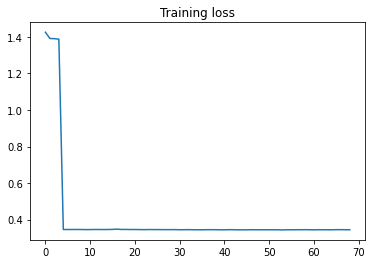

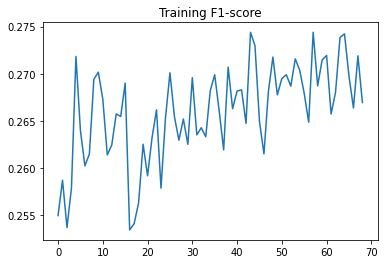

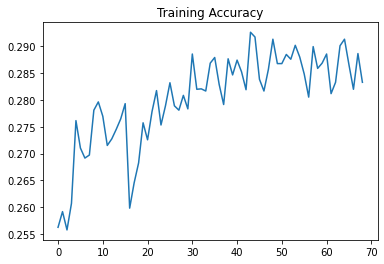

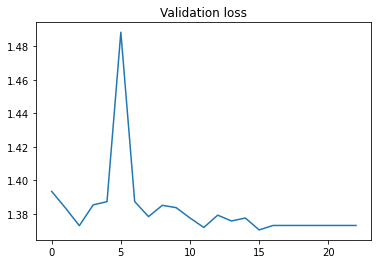

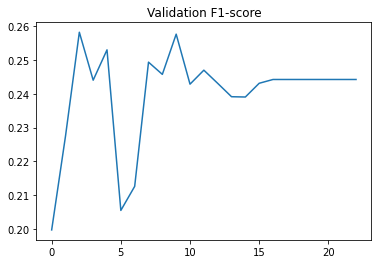

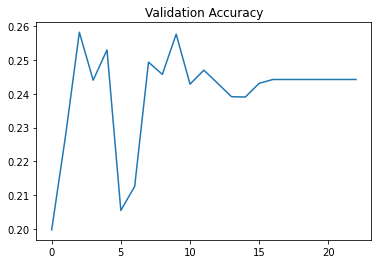

In [ ]:
for plot_title, plot_list in zip(
    ["Training loss", "Training F1-score", "Training Accuracy", "Validation loss", "Validation F1-score", "Validation Accuracy"]
    , [loss_list_train, f1_score_list_train, acc_list_train, loss_list_dev, f1_score_list_dev, acc_list_dev]
):
  plt.plot(plot_list)
  plt.title(plot_title)
  plt.show()

# Testing

## Load the best model

In [ ]:
model.load_state_dict(torch.load(model_path))
model.eval()
class_dim = -1

## Validate again to get the best score

Show validation result of the best model

In [ ]:
# Validate
epoch_loss_dev, epoch_metrics_dev, label_all, pred_all = Valid(
  model = model
  , loss_fn = loss_fn
  , data_loader = dev_loader
  , polarity_txt = POLARITY_TXT
  , device = device
)

for metric_name in ["F1_SCORE_PER_CLS", "ACC_PER_CLS", "TPR", "TNR"]:
  for polarity_cls, polarity_txt_val in enumerate(POLARITY_TXT):
    score_val = epoch_metrics_dev[metric_name][polarity_cls]
    score_name = f"{metric_name}_{polarity_txt_val}"
    print(f"{score_name} is {score_val}")
    if USE_WANDB:
      wandb.run.summary[f"valid_best/{score_name}"] = score_val
  print()

100%|██████████| 76770/76770 [1:04:30<00:00, 19.83it/s]


F1_SCORE_PER_CLS_not_mentioned is 0.5668707587726051
F1_SCORE_PER_CLS_negative is 0.08460013218770655
F1_SCORE_PER_CLS_neutral is 0.18297406534186594
F1_SCORE_PER_CLS_positive is 0.1630841121495327

ACC_PER_CLS_not_mentioned is 0.5236029699101211
ACC_PER_CLS_negative is 0.7654682818809431
ACC_PER_CLS_neutral is 0.7472189657418262
ACC_PER_CLS_positive is 0.7200468933177022

TPR_not_mentioned is 0.46309984520123837
TPR_negative is 0.26743812279009965
TPR_neutral is 0.34198929807994966
TPR_positive is 0.134016

TNR_not_mentioned is 0.6482263850139498
TNR_negative is 0.7865026676984482
TNR_neutral is 0.7837849352419904
TNR_positive is 0.869801292010794



Plot Confusion matrix

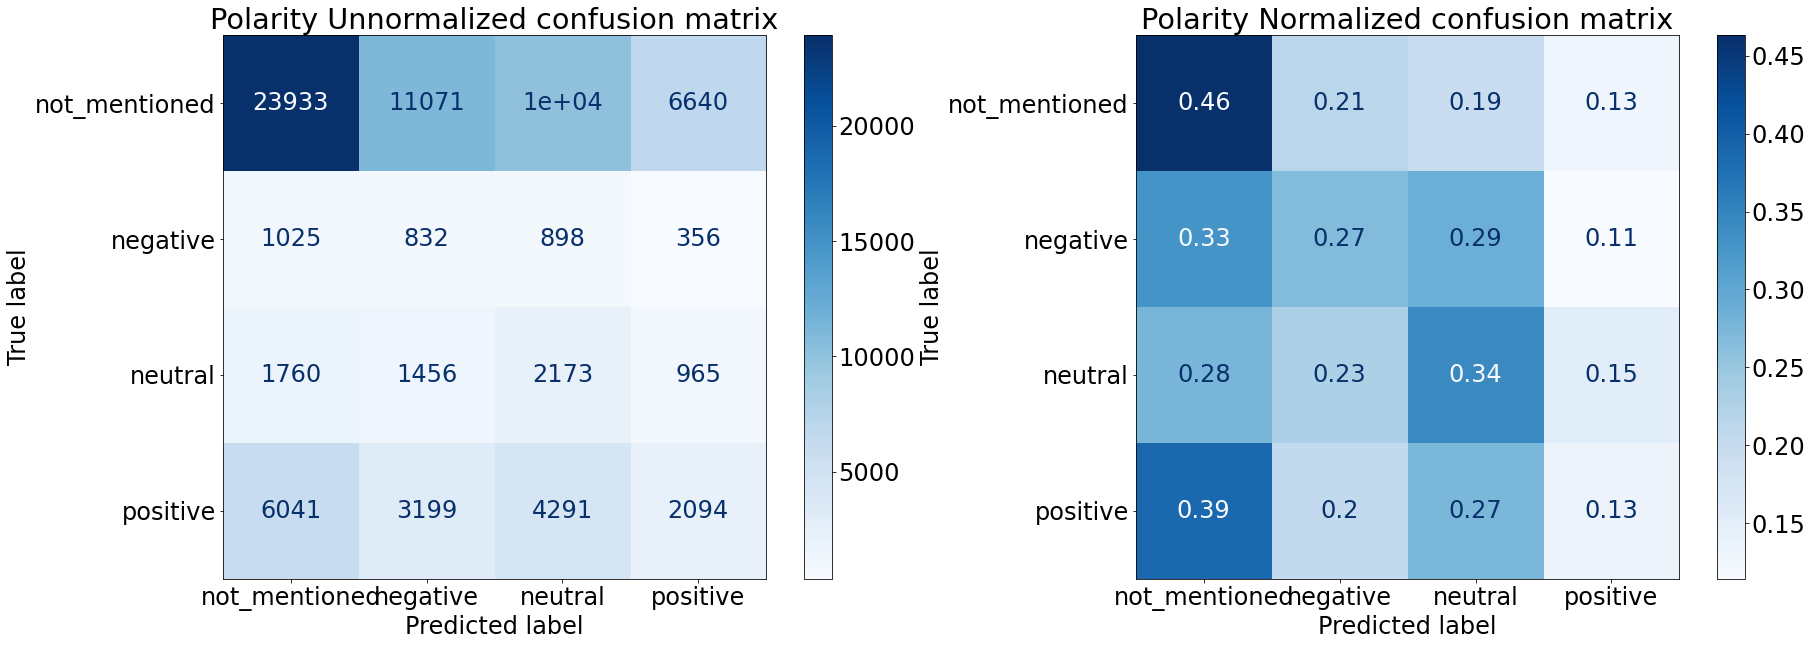

In [ ]:
"""
Change font size globally.
https://stackabuse.com/change-font-size-in-matplotlib/
"""
original_font_size = plt.rcParams["font.size"]
plt.rcParams["font.size"] = "24"
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

axs[0].title.set_text("Polarity Unnormalized confusion matrix")
ConfusionMatrixDisplay.from_predictions(y_true=label_all, y_pred=pred_all, cmap="Blues", display_labels=POLARITY_TXT, ax=axs[0])

axs[1].title.set_text("Polarity Normalized confusion matrix")
ConfusionMatrixDisplay.from_predictions(y_true=label_all, y_pred=pred_all, normalize="true", cmap="Blues", display_labels=POLARITY_TXT, ax=axs[1])

"""
20220205 Andy
Windows環境下，/會有invalid filename的error
去除/後，結果會放在Hidden Panels
"""
# wandb.log({"Media/test": plt})
if USE_WANDB:
  wandb.log({"valid_best": plt})
plt.show()
plt.rcParams["font.size"] = original_font_size

## Output csv for submission

In [ ]:
df_task1 = pd.DataFrame()
header_task1 = pd.Series(["id-#aspect", "predicted"])
df_task1 = df_task1.append(header_task1, ignore_index=True)

df_task2 = pd.DataFrame()
header_task2 = pd.Series(["id-#aspect", "sentiment"])
df_task2 = df_task2.append(header_task2, ignore_index=True)

for batch in tqdm(test_loader):
  review_id, aspect_id, input_ids_list, attention_mask_list, aspect_eng_batch = batch
  review_id, aspect_id, input_ids_list, attention_mask_list = review_id.to(device), aspect_id.to(device), input_ids_list.to(device), attention_mask_list.to(device)
  """
  20220523 Andy
  Polarity的shape必須是[N]，而非[]，
  作為CrossEntropyLoss的target，才會正常，
  否則會出現error：
  IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)
  https://stackoverflow.com/a/48389451/3513289
  """
  review_id, aspect_id, input_ids_list, attention_mask_list = torch.squeeze(review_id, 0), torch.squeeze(aspect_id, 0), torch.squeeze(input_ids_list, 0), torch.squeeze(attention_mask_list, 0)

  with torch.no_grad():
    aspect_logits_list = model(input_ids=input_ids_list, attention_mask=attention_mask_list)
  """
  logits.shape is torch.Size([4, 4])
  logits is tensor([[-0.1762, -0.4194,  1.0980,  0.3753],
          [ 0.6431, -0.9851,  0.4553,  0.3383],
          [ 0.7950, -1.2446,  0.2184, -0.2827],
          [ 0.0183,  0.5071,  0.2663, -0.2459]], device='cuda:0')
  """
  # print(f"len(aspect_logits_list) is {len(aspect_logits_list)}")
  # print(f"aspect_logits_list[0].shape is {aspect_logits_list[0].shape}")
  # print()

  """
  aspect_logits_list range is [0, 17]
  aspect_logits.shape is torch.Size([4, 4])
  aspect_logits is tensor([[-0.0598, -0.8929, -0.9081,  0.1308],
          [ 0.2358,  0.0991, -0.6909, -0.2804],
          [ 0.0367, -0.1897, -1.2280,  0.5199],
          [-1.2748, -1.2478, -0.3033, -0.0239]], device='cuda:0')
  """
  aspect_logits = aspect_logits_list[aspect_id - 1]
  # print(f"aspect_logits.shape is {aspect_logits.shape}")
  # print(f"aspect_logits is {aspect_logits}")
  # print()

  ans_window, max_index_review, max_prob_review = GetMaxPolarity(aspect_logits, class_dim)
  # print(f"logits[ans_window].shape is {logits[ans_window].shape}")
  logits_ans_window = torch.unsqueeze(aspect_logits[ans_window], dim=0)
  # print(f"logits_ans_window.shape is {logits_ans_window.shape}")

  review_id = review_id.item()
  aspect_id = aspect_id.item()
  max_index_review = max_index_review.detach().cpu().numpy()

  # Task 1
  predicted = ""
  if max_index_review != 0:
    predicted = review_id
  # 190-1,190
  new_row_task1 = [f"{review_id}-{aspect_id}", predicted]
  new_row_task1 = pd.Series(new_row_task1)
  df_task1 = df_task1.append(new_row_task1, ignore_index=True)

  # Task 2
  # Shift polarity from [0, 3] back to [-2, 1]
  sentiment = max_index_review - 2
  # 190-1,1
  new_row_task2 = [f"{review_id}-{aspect_id}", sentiment]
  new_row_task2 = pd.Series(new_row_task2)
  df_task2 = df_task2.append(new_row_task2, ignore_index=True)

print()
"""
結果示意：
id-#aspect  predicted
190-1           

id-#aspect  sentiment
190-1        -2
"""
df_task1.to_csv(f"Sentiment_Analysis/submission_task1_{brief_name}.csv", header=False, index=False)
print(df_task1.to_string(header=False))
print()
df_task2.to_csv(f"Sentiment_Analysis/submission_task2_{brief_name}.csv", header=False, index=False)
print(df_task2.to_string(header=False))

100%|██████████| 76050/76050 [1:11:02<00:00, 17.84it/s]


串流輸出內容已截斷至最後 5000 行。
71052     41735-6           
71053     41735-7           
71054     41735-8      41735
71055     41735-9           
71056    41735-10           
71057    41735-11           
71058    41735-12      41735
71059    41735-13           
71060    41735-14      41735
71061    41735-15           
71062    41735-16      41735
71063    41735-17           
71064    41735-18           
71065     21887-1           
71066     21887-2           
71067     21887-3           
71068     21887-4      21887
71069     21887-5           
71070     21887-6           
71071     21887-7      21887
71072     21887-8      21887
71073     21887-9           
71074    21887-10           
71075    21887-11           
71076    21887-12      21887
71077    21887-13           
71078    21887-14      21887
71079    21887-15           
71080    21887-16      21887
71081    21887-17           
71082    21887-18           
71083      3124-1       3124
71084      3124-2       3124
71085      3124-3     

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Finish wandb

In [ ]:
if USE_WANDB:
  wandb.finish()

wandb: Processing terminal output (stdout)...
wandb: Terminal output too large. Logging without processing.
wandb: Done.


train/ASAP_acc,▄▁▇▄▅▆▁▃▇█▅▂▆▃
train/ASAP_f1_score,▃▁█▄▆▆▂▃██▅▂▆▃
train/ASAP_f1_score_negative,▆▁▇▅█▃▂▃▃▅▄▅▆▅
train/ASAP_f1_score_neutral,▂▁▅▄▆▄▂▇█▂▆▁▃▅
train/ASAP_f1_score_not_mentioned,▄▃▄▅▃▆▂▁▄█▄▃▆▃
train/ASAP_f1_score_positive,▃▆▇▂▃▇▆▄▆█▂▅▄▁
train/ASAP_loss,▃▅▅▇▆▁▆▄▅▂▇█▄▅
train/ASAP_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/ASAP_acc,▁▁▁▁▁▁▁
valid/ASAP_f1_score,▁▁▁▁▁▁▁
valid/ASAP_f1_score_negative,▁▁▁▁▁▁▁
